## Introduction

A Bike sharing system is a shared transport service where bicycles are available for shared use by individuals at low cost. It allows individuals borrow a bicycle from a station, ride it to a specific destination and then return it to any station within the system. Bike sharing presents benefits such as convenience, affordability, eco-friendly and it is a great way for bikers to get some exercise and fresh air.

In this notebook, we analyse the total hourly demand of bikes in all stations in Washington DC. This bike service is provided by [Capital bikeshare](https://capitalbikeshare.com/) where an individual can unlock a bike by scanning its QR code using an app, ride on it and then park it at the nearest docking station in their destination. Two types of bikes are provided - electric (E-bikes) and classic bikes- and an individual can rent them on short-term option by renting a single ride, obtain a day pass or monthly membership and long-term by an annual membership option.

## Dataset Description

Dataset includes hourly bike rides made by registered and casual users for each bike type. It also includes the total distance travelled and the average duration of the trip in seconds.

Variable | Description
---------| -----------
rideable_type | Type of bike (E-bike or classic bike)
pickup hour   | Date and time (in hour of day) of pickup
member_casual | Indicates if user is a registered member or casual user.<br>A member is one who is an annual member, 30-day member of day key member.<br>A casual ride includes single trips, 1, 3, or 5-day Pass
num_rides     | Total number of bike rides
duration_secs | Average duration of trips in seconds
distance_km   | Total distance travelled in kilometres
duration_mins | The average duration in minutes

## Analysis Plan

In this analysis, we will investigate the hourly demand for bikes by residents of Washington DC between Jan 2022 and June 2024. We want to understand

-   The performance of bike sharing in Washington DC
-   The acceptance of bike sharing system by Washington DC residents
-   The bike type preference of residents
-   Bike demands at specific hours of the day, day of the week, or month or season of the year for better service.

## Data Exploration

In this section, we load our libraries and dataset, check for data quality issues, and do some preliminary data exploration and summary statistics

### Loading libraries and dataset

In [1]:
# load libraries
library(tidyverse)
library(lubridate)
library(ggthemes)
library(ggpubr)

Warning message:
"package 'ggplot2' was built under R version 4.3.3"
── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'ggthemes' was built under R version 4.3.3"


In [2]:
# read dataset
bike_shares = read_csv('../data/bike_shares.csv', show_col_types=FALSE)

head(bike_shares) %>%
    kableExtra::kable(digits=2, caption='Top 6 rows')



Table: Top 6 rows

|rideable_type |pickup_hour         |member_casual | num_rides| duration_secs| distance_km| duration_mins|
|:-------------|:-------------------|:-------------|---------:|-------------:|-----------:|-------------:|
|classic       |2022-01-01 00:00:00 |casual        |        74|       1423.28|       83.64|         23.72|
|classic       |2022-01-01 00:00:00 |member        |        46|        824.13|       48.38|         13.74|
|classic       |2022-01-01 01:00:00 |casual        |        62|       5765.03|       68.64|         96.08|
|classic       |2022-01-01 01:00:00 |member        |        52|       2460.02|       48.86|         41.00|
|classic       |2022-01-01 02:00:00 |casual        |        53|       1260.09|       61.44|         21.00|
|classic       |2022-01-01 02:00:00 |member        |        40|       1332.97|       32.82|         22.22|

### Data Quality checks

In [3]:
# checking for missing values and duplicate rows
anyDuplicated(bike_shares)
anyNA(bike_shares)

# No duplicate rows or missing values

[1] 0

[1] FALSE

### Descriptive statistics

In [4]:
# skimr::skim(bike_shares)

In [5]:
ggpubr::get_summary_stats(bike_shares) %>%
    kableExtra::kable(format.args=list(big.mark=','))



|variable      |      n|  min|           max|  median|      q1|        q3|     iqr|     mad|      mean|         sd|      se|      ci|
|:-------------|------:|----:|-------------:|-------:|-------:|---------:|-------:|-------:|---------:|----------:|-------:|-------:|
|num_rides     | 86,624| 1.00|      1,054.00|  61.000|  19.000|   171.000| 152.000|  78.578|   117.639|    138.921|   0.472|   0.925|
|duration_secs | 86,624| 2.00| 12,416,775.64| 816.960| 669.260| 1,138.663| 469.403| 283.410| 1,306.695| 43,991.862| 149.470| 292.959|
|distance_km   | 86,624| 0.00|     16,526.46|  60.956|  18.756|   156.844| 138.088|  76.401|   110.560|    148.942|   0.506|   0.992|
|duration_mins | 86,624| 0.03|    206,946.26|  13.620|  11.150|    18.980|   7.830|   4.729|    21.778|    733.198|   2.491|   4.883|

In [6]:
unique(bike_shares$rideable_type)
unique(bike_shares$member_casual)

[1] "classic"  "electric"

[1] "casual" "member"

### Preliminary Data Exploration

- Here, we will look at the distribution of the variables. For the numerical variables, we will use the histogram, density plots and boxplots while the categorical variables we will use the frequency distribution

In [7]:
fig.size <- function(width, height){
    options(repr.plot.width=width, repr.plot.height=height)
}

In [8]:
plot_frequency <- function(data, colname=NULL, title=NULL){
    df <- data |>
    group_by(.data[[colname]]) |>
    count() |>
    ungroup() |>
    mutate(perc = 100*n/sum(n))
    
    ggplot(data=df, aes(x=.data[[colname]], y=n)) +
    geom_col(fill='steelblue') +
    geom_text(aes(x=.data[[colname]], y=n, label=paste0(round(perc,2),'%')), 
              vjust=1.4, fontface='bold', color='white') +
    theme_tufte() +
    theme(plot.title=element_text(hjust=-.5),
          text = element_text(size=16.5)) +
    labs(title=title, x=colname, y='Frequency') +
    scale_y_continuous(breaks=seq(0,44000,7500), 
                       labels=scales::label_number(scale=1e-3, suffix='K'))
}

In [9]:
plot_distribution <- function(data, colname=NULL, fill=NULL, title=NULL){
    if (is.null(fill)) {
        box <- ggboxplot(data, y=colname, width=0.4, fill='steelblue', title=title) + 
        theme_tufte() +
        theme(plot.title=element_text(face='bold'),
              text = element_text(size=16.5))
        
        hist_ <- gghistogram(data, x=colname, fill='steelblue', bins=40) + 
        theme_tufte() +
        theme(plot.title=element_text(face='bold'), 
              text = element_text(size=16.5))
        
        ggarrange(box, hist_, ncol=2) 
    } else{
        box <- ggboxplot(data, x=fill, y=colname, width=0.4, fill=fill, title=title) + 
        theme_tufte() +
        theme(plot.title=element_text(face='bold'), 
              text = element_text(size=16.5))
        
        hist_ <- gghistogram(data, x=colname, fill=fill, alpha=0.6, bins=40) + 
        theme_tufte() +
        theme(plot.title=element_text(face='bold'),
              text = element_text(size=16.5))
        
        ggarrange(box, hist_, ncol=2, common.legend=T, legend='right')
    }
}

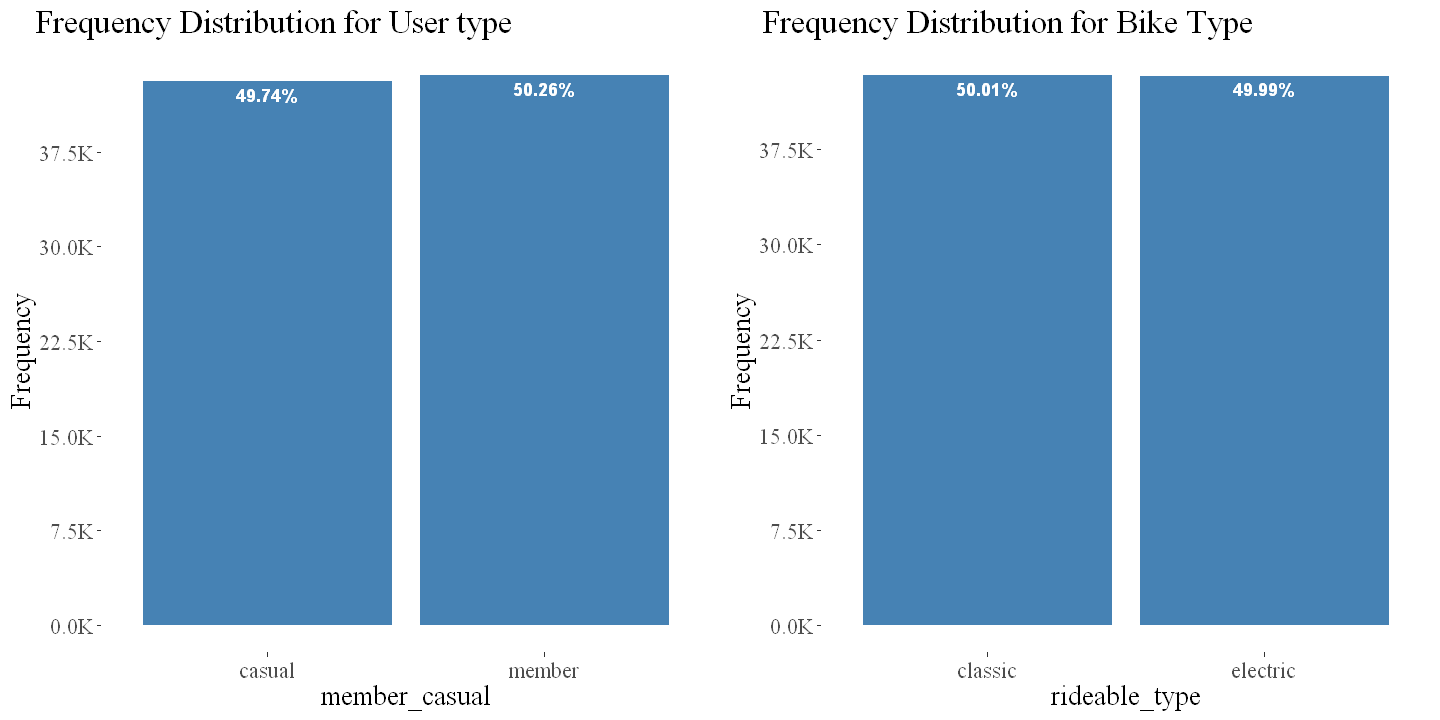

In [10]:
# categorical variables
fig.size(12,6)
a = plot_frequency(bike_shares, 'member_casual', title='Frequency Distribution for User type')
b = plot_frequency(bike_shares, 'rideable_type', title='Frequency Distribution for Bike Type')

ggarrange(a, b, ncol=2)

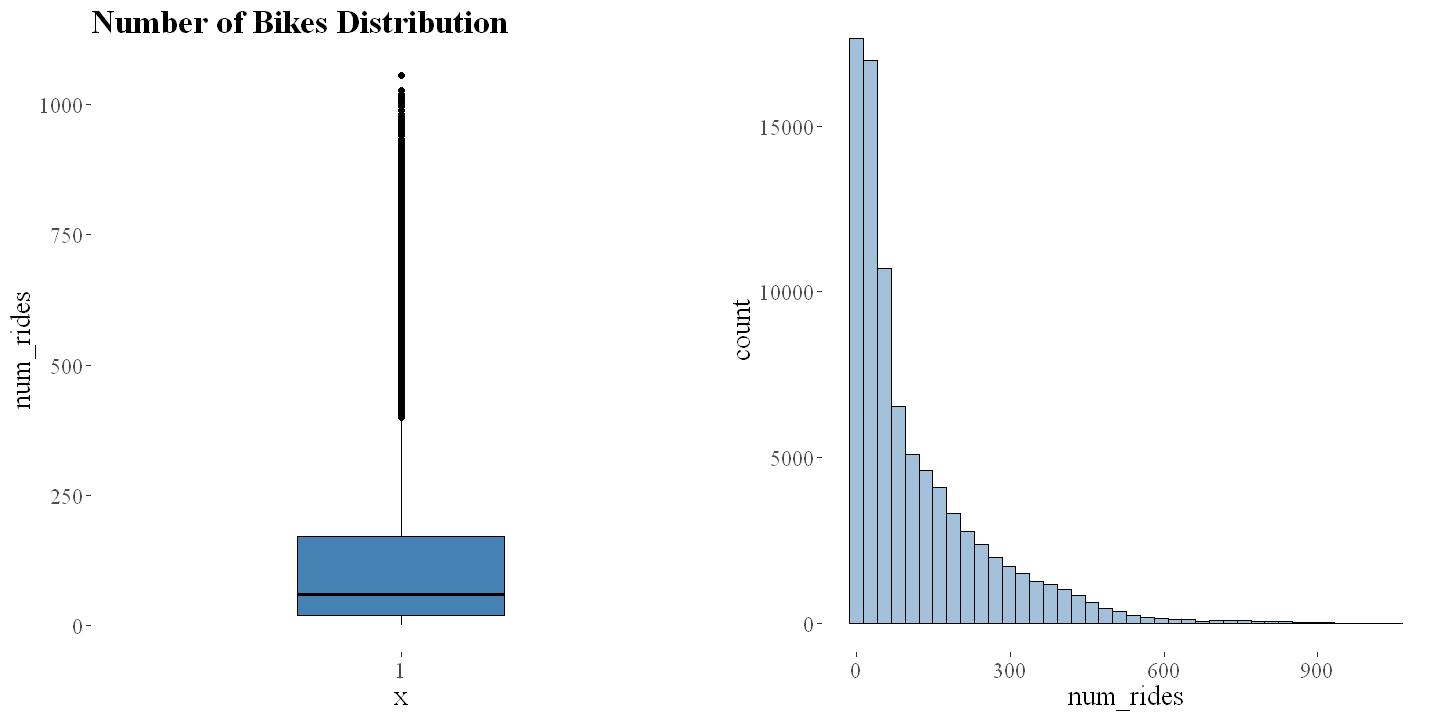

In [11]:
# numerical variables
fig.size(12,6)
plot_distribution(bike_shares, 'num_rides', title='Number of Bikes Distribution')

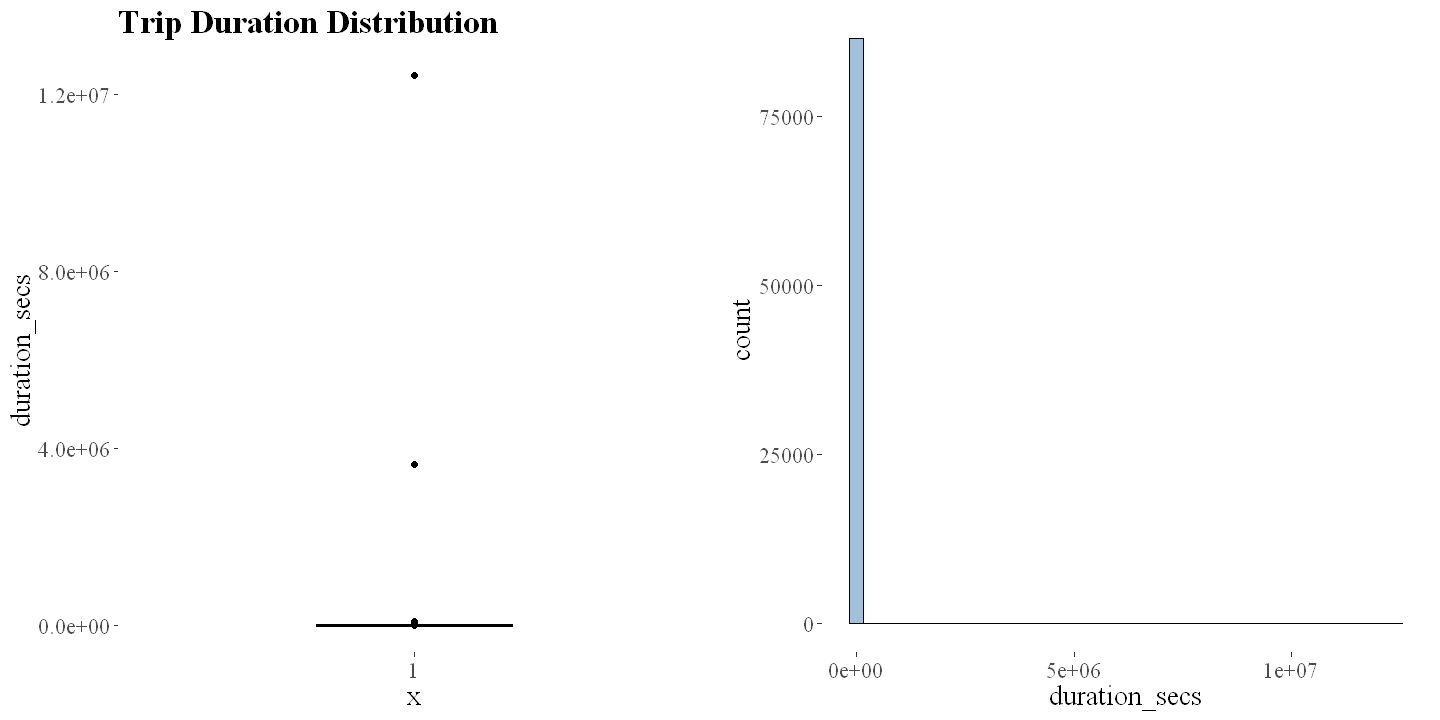

In [12]:
fig.size(12,6)
plot_distribution(bike_shares, 'duration_secs', title='Trip Duration Distribution')

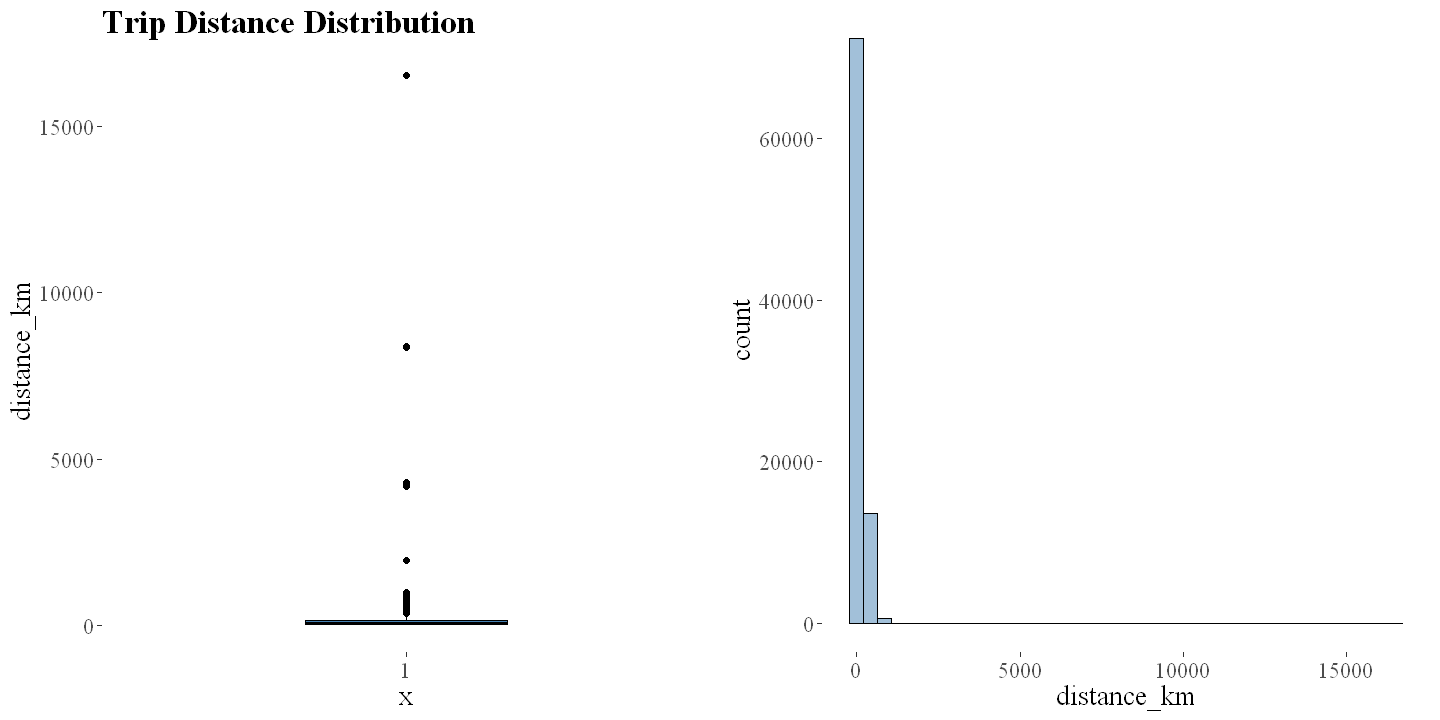

In [13]:
fig.size(12,6)
plot_distribution(bike_shares, 'distance_km', title='Trip Distance Distribution')

There are some strange data points in the distance and duration variables. We will clean them.

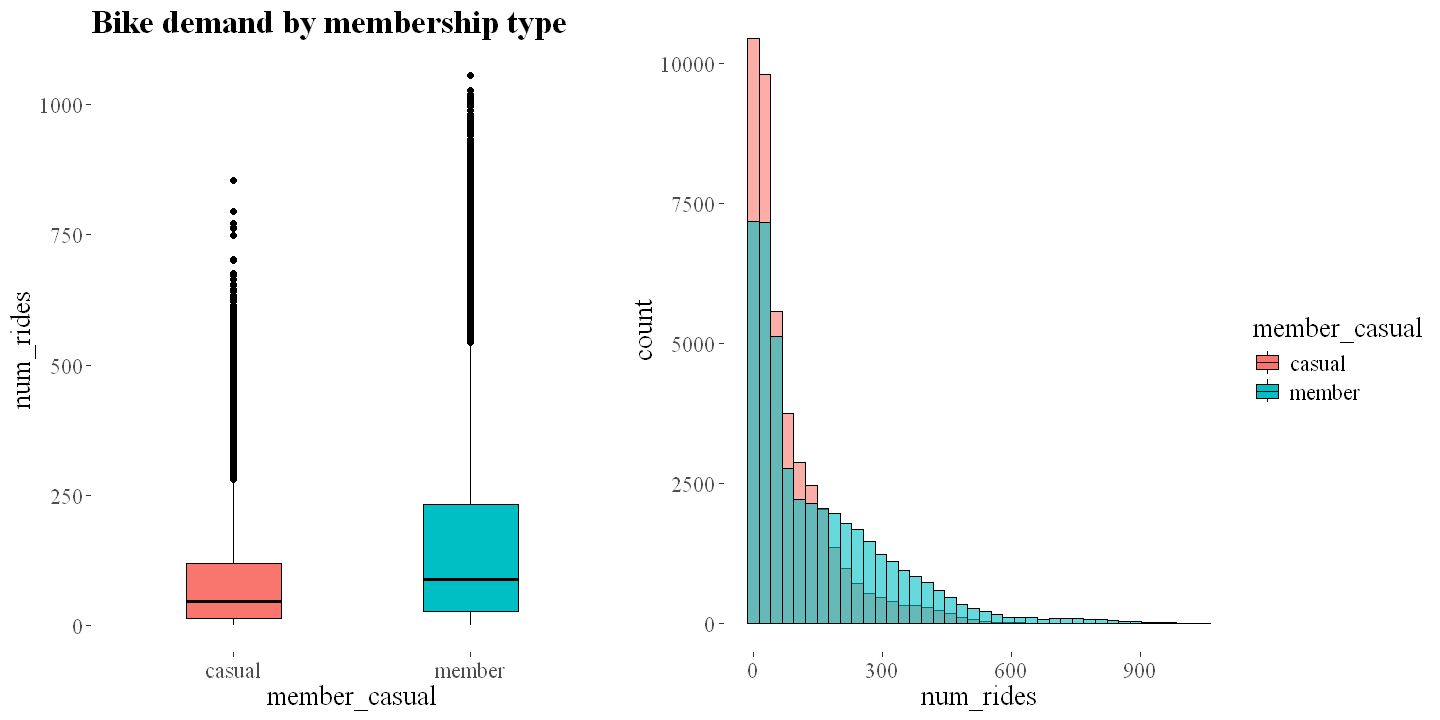

In [14]:
# bivariate
fig.size(12,6)
plot_distribution(bike_shares, 'num_rides', fill='member_casual',
                  title='Bike demand by membership type')

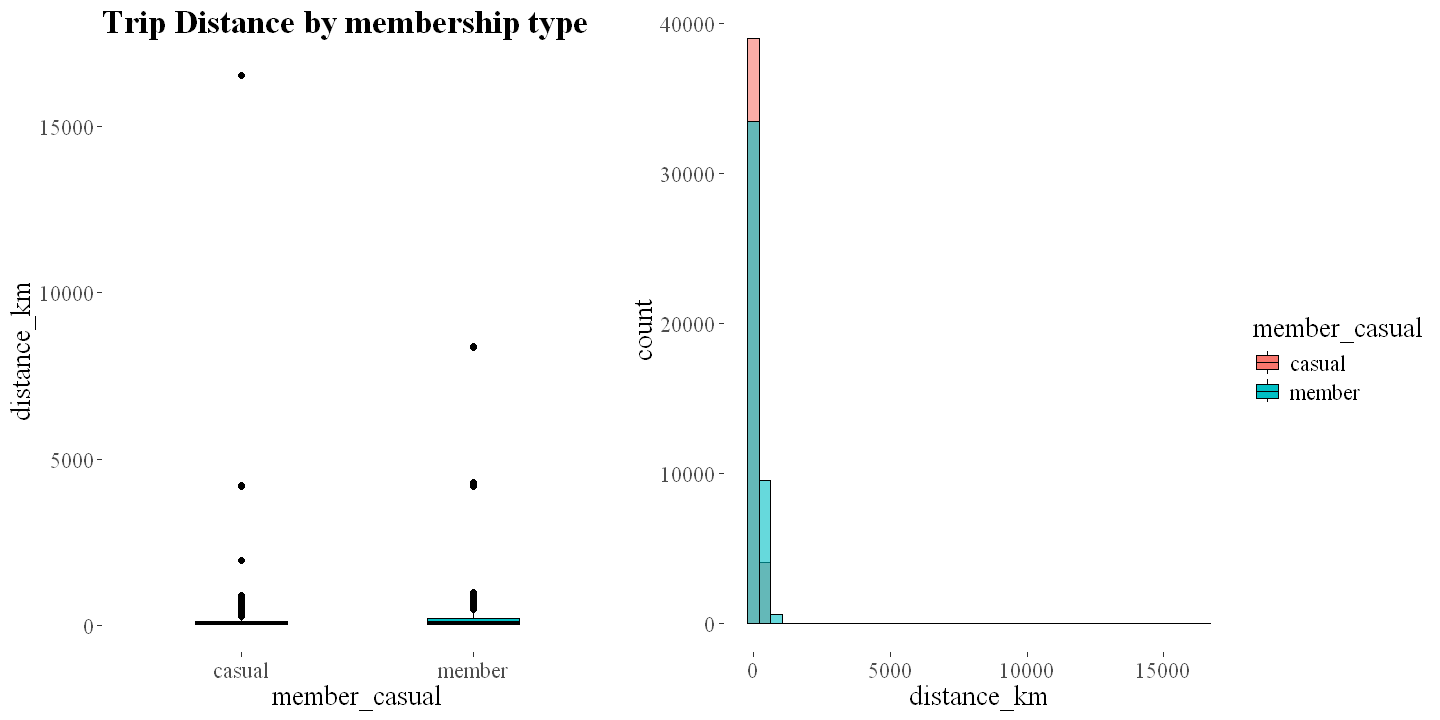

In [15]:
fig.size(12,6)
plot_distribution(bike_shares, 'distance_km', fill='member_casual', 
                  title='Trip Distance by membership type')

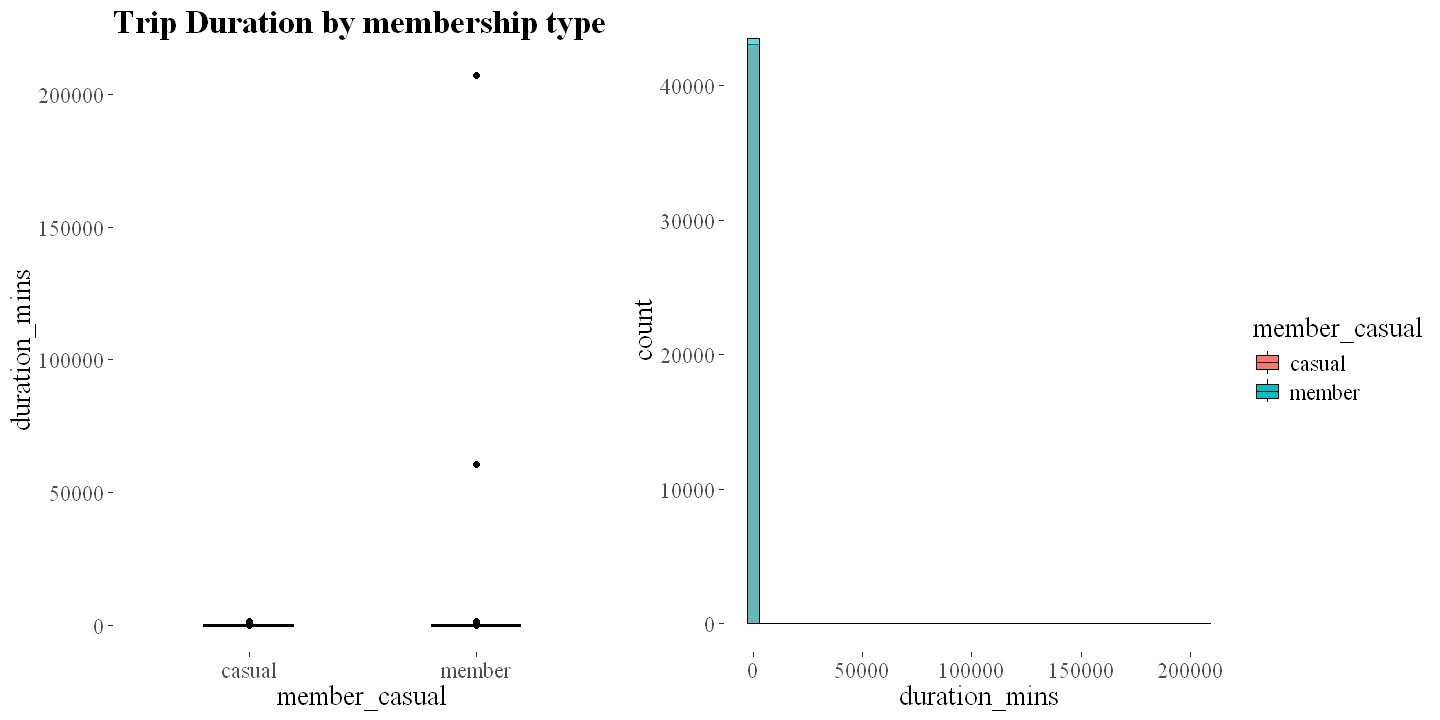

In [16]:
fig.size(12,6)
plot_distribution(bike_shares, 'duration_mins', fill='member_casual', 
                  title='Trip Duration by membership type')


### Data cleaning

Here, we will remove the extreme values from the duration and distance variables. For the duration, we will bin values above 24 hours (1440 mins or 86400 secs) to 24 hours in minutes or seconds. For distance, we will replace values above 1500km to 1500km

In [17]:
# clean data
bike_shares <- bike_shares |>
    # binning
    mutate(distance_km = ifelse(distance_km > 1500, 1500, distance_km),
           duration_secs = ifelse(duration_secs > 24*3600, 24*3600, duration_secs),
           duration_mins = ifelse(duration_mins > 24*60, 24*60, duration_mins)) |>
    # convert to factor variables
    mutate(across(where(is.character), as.factor))

## Analysis

### Questions

##### What is the average number of bikes shared in all stations in an hour? What is the average distance and duration travelled by users?

In [18]:
data.frame(`Total_Rides` = sum(bike_shares$num_rides),
           `Average_Hourly_Demand` = mean(bike_shares$num_rides),
           `Average_Distance_km` = mean(bike_shares$distance_km/bike_shares$num_rides),
           `Average_Duration_mins` = mean(bike_shares$duration_mins)) %>% 
    t() %>%
    data.frame(Values=.) %>%
    rownames_to_column('Name') %>%
    kableExtra::kable(caption='Bike Performance', align='lr', digits=2, 
                      format.args=list(big.mark=","))



Table: Bike Performance

|Name                  |        Values|
|:---------------------|-------------:|
|Total_Rides           | 10,190,395.00|
|Average_Hourly_Demand |        117.64|
|Average_Distance_km   |          1.00|
|Average_Duration_mins |         18.71|

##### How do the metrics above compare by bike type and membership type?

In [19]:
# by membership type
bike_shares |>
    reframe(Average_Hourly_demand = mean(num_rides), 
            Average_Distance_km = mean(distance_km/num_rides),
            Average_Duration_mins = mean(duration_mins), 
            .by=member_casual) |>
    pivot_longer(cols = -member_casual) |>
    pivot_wider(id_cols = name, names_from=member_casual, values_from=value) %>%
    kableExtra::kable(align='lrr', digits=2, caption='Performance by Membership Type',
                      col.names=c('Name', 'Non-members', 'Members'))



Table: Performance by Membership Type

|Name                  | Non-members| Members|
|:---------------------|-----------:|-------:|
|Average_Hourly_demand |       84.18|  150.76|
|Average_Distance_km   |        1.04|    0.96|
|Average_Duration_mins |       23.81|   13.67|

In [20]:
# by bike type
bike_shares |>
    reframe(Average_Hourly_demand = mean(num_rides), 
            Average_Distance_km = mean(distance_km/num_rides),
            Average_Duration_mins = mean(duration_mins), 
            .by=rideable_type) |>
    pivot_longer(cols = -rideable_type) |>
    pivot_wider(id_cols = name, names_from=rideable_type, values_from=value) %>%
    kableExtra::kable(digits=2, caption='Performance by Bike Type',
                      col.names=c('Name', 'Classic', 'Electric'))




Table: Performance by Bike Type

|Name                  | Classic| Electric|
|:---------------------|-------:|--------:|
|Average_Hourly_demand |  161.84|    73.42|
|Average_Distance_km   |    0.87|     1.12|
|Average_Duration_mins |   23.37|    14.06|

##### What is the percentage of rides by membership type and bike type?

In [21]:
# function that aggregates a numerical variable based on a given group
aggregate_data <- function(data, column, groups, return_perc=T, func=sum){
    select_cols = c(column, groups)
    df <- data[,select_cols] |>
    group_by(across(all_of(groups))) |>
    summarize(total = func(.data[[column]])) |>
    mutate(perc = total/sum(total))
    if (return_perc){
        return(df)
    } else{
     return(df %>% select(-perc))   
    }
}

-   Bike Type

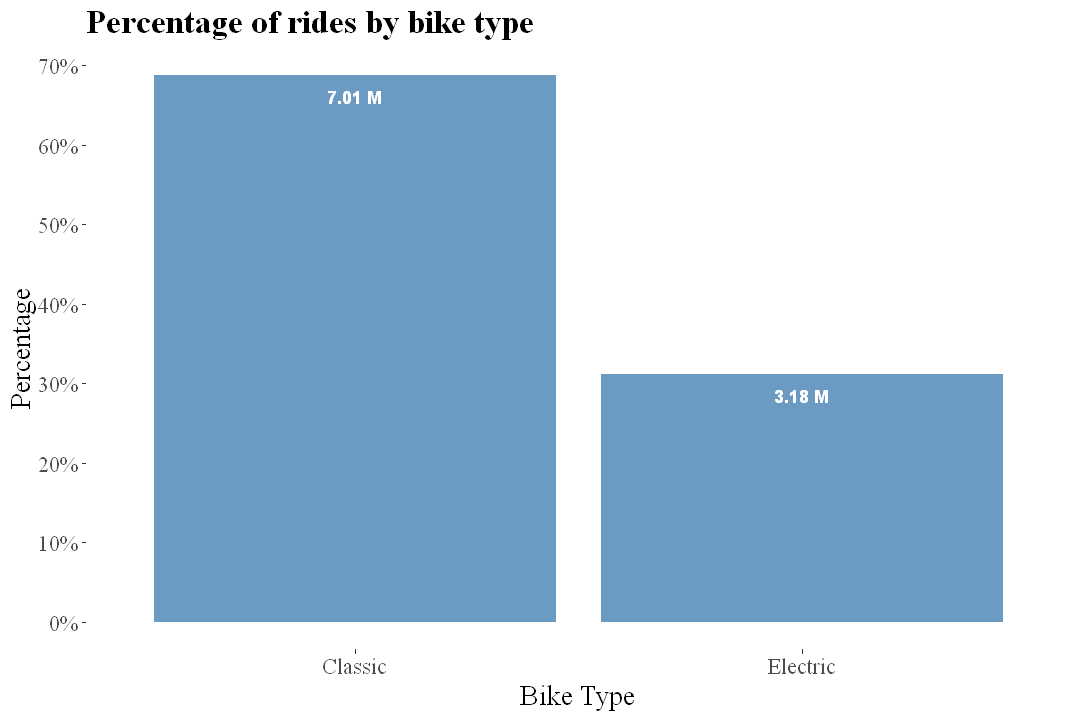

In [22]:
fig.size(9,6)
aggregate_data(bike_shares, 'num_rides', 'rideable_type') |>
    ggplot(aes(x=rideable_type, y=perc)) +
    geom_col(fill='steelblue', alpha=0.8) +
    geom_text(aes(label=paste(round(total/1e6,2),'M')), vjust=2, 
              fontface='bold', color='white') +
    theme_tufte() +
    theme(legend.position='none',
          plot.title=element_text(face='bold'),
          text = element_text(size=16.5)) + 
    labs(title='Percentage of rides by bike type', x='Bike Type', y='Percentage') +
    scale_y_continuous(labels=scales::label_percent(suffix='%'), breaks=seq(0,1,.1)) +
    scale_x_discrete(labels=c('Classic', 'Electric'))

-   Membership Type

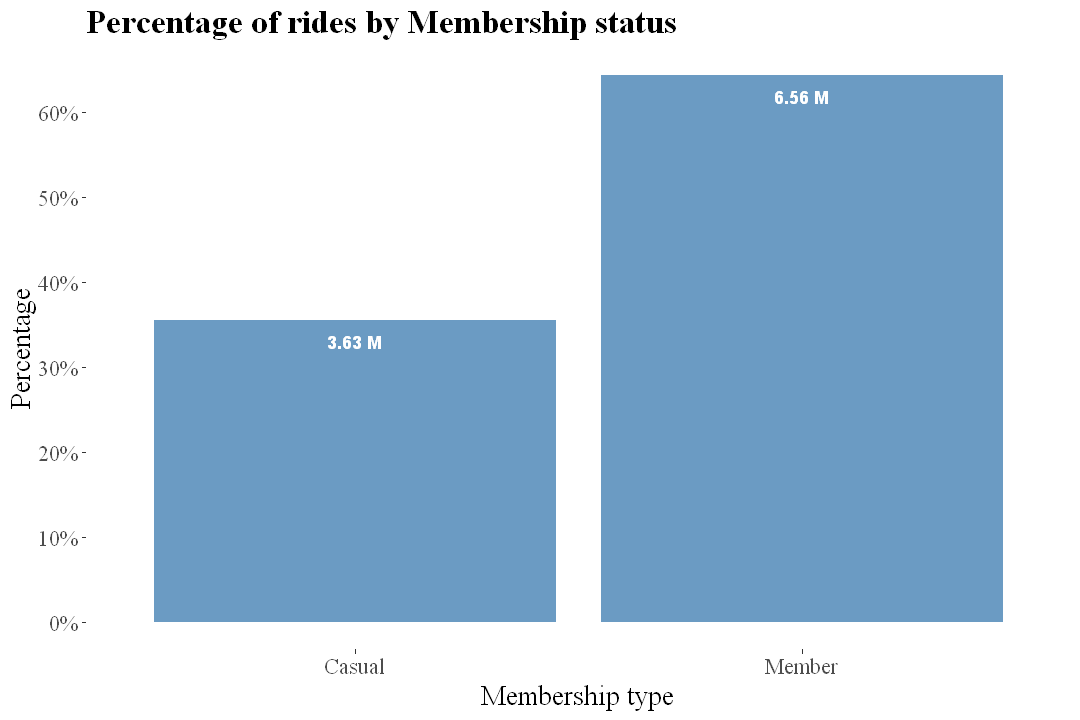

In [23]:
fig.size(9,6)
aggregate_data(bike_shares, 'num_rides', 'member_casual') |>
    ggplot(aes(x=member_casual, y=perc)) +
    geom_col(fill='steelblue', alpha=0.8) +
    geom_text(aes(label=paste(round(total/1e6,2),'M')), vjust=2, 
              fontface='bold', color='white') +
    theme_tufte() +
    theme(legend.position='none',
          plot.title=element_text(face='bold'),
          text = element_text(size=16.5)) + 
    labs(title='Percentage of rides by Membership status', 
         x='Membership type', y='Percentage') +
    scale_y_continuous(labels=scales::label_percent(suffix='%'), breaks=seq(0,1,.1)) +
    scale_x_discrete(labels=c('Casual', 'Member'))

-   Membership type vs Bike Type

In [24]:
aggregate_data(bike_shares, 'num_rides', c('member_casual', 'rideable_type')) %>%
    inner_join(
        aggregate_data(bike_shares, 'num_rides', c('rideable_type', 'member_casual')), 
        by=c('rideable_type', 'member_casual', 'total'), 
        suffix=c('_member_vs_bike_type', '_bike_vs_member_type')) %>%
    mutate(across(contains('perc'), \(x) 100*x)) %>%
    kableExtra::kable(digits=2, caption='Performance by Bike Type vs Membership Type', 
                      format.args=list(big.mark=','))

`summarise()` has grouped output by 'member_casual'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'rideable_type'. You can override using the `.groups` argument.




Table: Performance by Bike Type vs Membership Type

|member_casual |rideable_type |     total| perc_member_vs_bike_type| perc_bike_vs_member_type|
|:-------------|:-------------|---------:|------------------------:|------------------------:|
|casual        |classic       | 2,482,521|                    68.44|                    35.41|
|casual        |electric      | 1,144,702|                    31.56|                    36.00|
|member        |classic       | 4,528,211|                    68.99|                    64.59|
|member        |electric      | 2,034,961|                    31.01|                    64.00|

From the results above, we see that classic bikes are the most rented bike types than electric bikes while most of the rents came from registered users than unregistered users. Out of the over 10 million rides between January 2022 and June 2024, about 69% of them were rides from classic bikes while 31% of them were rides from an electric bike. On the other hand, 64% of all the rides were made by registered users while about 36% by casual users.

Drilling down, 35.4% of all rides from a classic bike and 36% from an electric bike were made by non-members. This means that about 64.6% and 64% of all the rides from a classic or electric bike were made by registered members of Capital Bikeshare. Similarly, out of all the unregistered users, 68.4% of them rented classic bikes against the about 69% of registered users, indicating that 31.6% and 31% of unregistered and registered users rented electric bikes, respectively.

##### What is the acceptance rate of bike sharing system Washington DC residents?

To determine the acceptance rate of bike sharing system, we will look at the percentage change of demand per day, week, month and year. This is enable us determine the growth rate at these timeframes

In [25]:
# adding time features
bike_shares <- bike_shares %>% mutate(year=year(pickup_hour), 
                                      month = month(pickup_hour),
                                      hour = hour(pickup_hour),
                                      week = week(pickup_hour),
                                      dow_num = wday(pickup_hour), # sum
                                      dow = wday(pickup_hour, label = T, abbr=T), # Sun
                                      day = day(pickup_hour))

In [26]:
# acceptance of bike rides
pct_change <- c()
for (i in c('hour', 'week', 'month', 'day')){
    res <- aggregate_data(bike_shares %>% mutate(date=floor_date(pickup_hour, i[1])), 
                          'num_rides', 'date') %>%
    mutate(pct = 100*(total-lag(total))/lag(total)) %>%
    reframe(avg_change = mean(pct, na.rm=T)) %>%
    pull(avg_change)
  pct_change <- append(pct_change, res)
}

names(pct_change) <- c('hour', 'week', 'month', 'day')

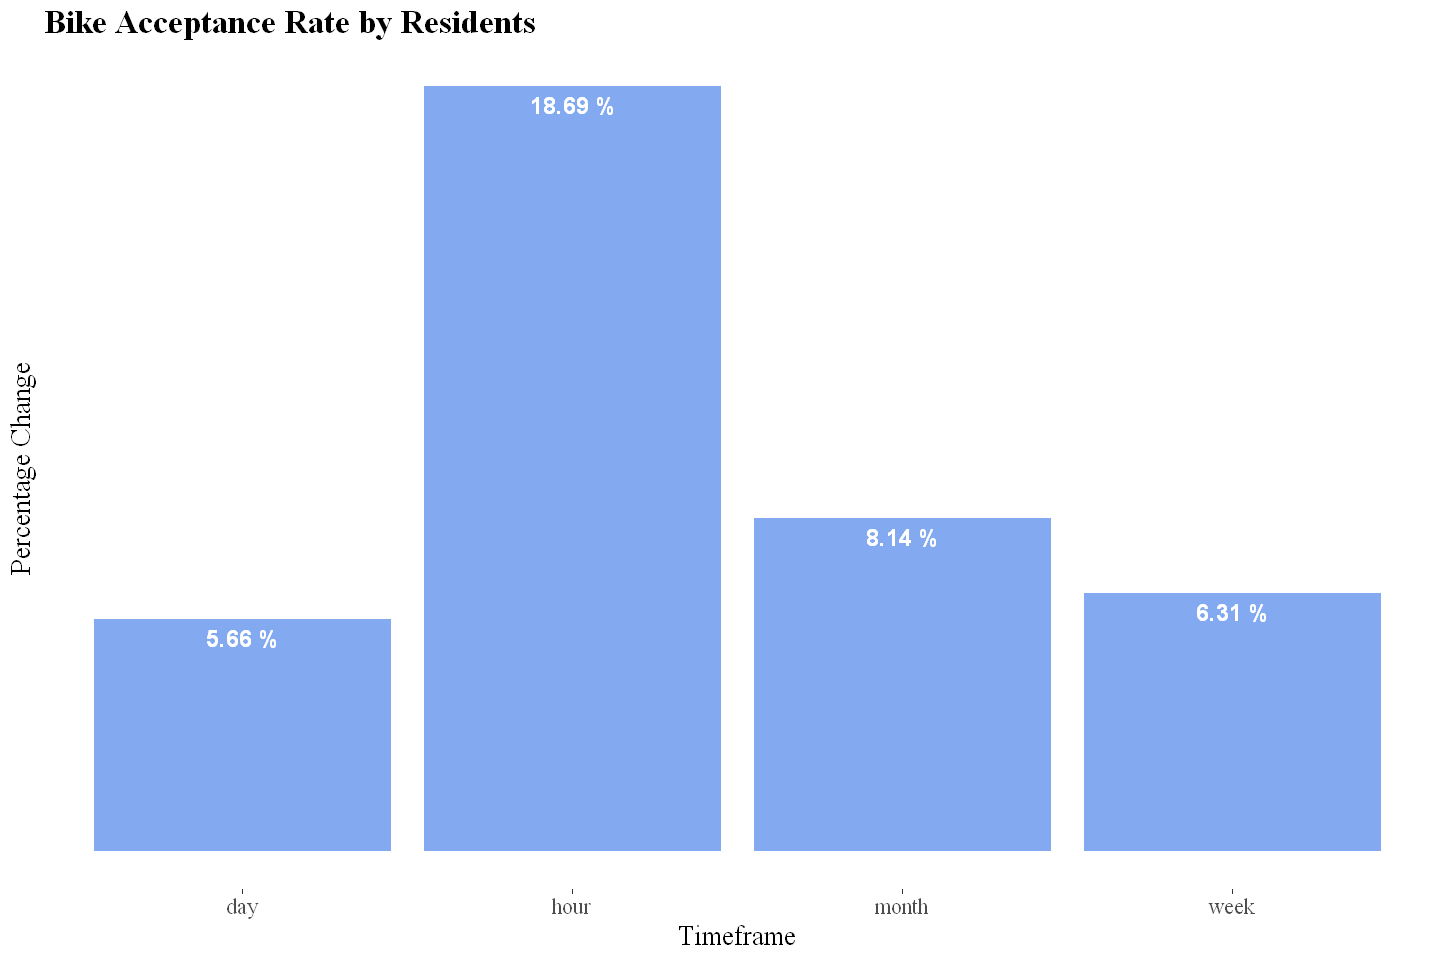

In [27]:
# visualise
fig.size(12,8)
data.frame(pct_change) |> 
  rownames_to_column('name') |> 
  ggplot(aes(name, pct_change)) +
  geom_col(fill='cornflowerblue', alpha=0.8) +
  geom_text(aes(label=paste(round(pct_change,2),'%')), vjust=1.5, 
            color='white', fontface='bold', size=5) + 
  theme_tufte() +
  theme(panel.grid=element_blank(), 
        text = element_text(size=16.5),
        axis.text.y = element_blank(),
        axis.ticks.y=element_blank(),
        plot.title=element_text(face='bold')) + 
  labs(title='Bike Acceptance Rate by Residents', 
       x='Timeframe', y='Percentage Change')

-   There's a positive acceptance of bike sharing by residents of Washington DC. By investigating the percentage change in bike demand at different time frames, we see that per hour of the day, the demand rate for bike sharing increases by about 18.7% on average, about 5.7% per day, 6.3% per week and about 8.1% per month of the year.

Next, we want to look at the rate at which residents demand each bike type per hour, day, week and month. This will be extended to the change in demand for bike rides by non-members and members and the demand for each bike type by non-members and members. With this, we want to understand at what time these groups have a higher demand for city bikes.

In [28]:
# acceptance by bike type
results <- data.frame(row.names=c('hour', 'week', 'month', 'day'),
                      classic=numeric(4), ebikes=numeric(4))

for (i in 1:2){
    bike_type <- c('classic', 'electric')[i]

    pct_change <- c()
    for (j in rownames(results)){
        res <- aggregate_data(bike_shares %>% 
                              filter(rideable_type == bike_type) %>%
                              mutate(date=floor_date(pickup_hour, j[1])), 
                              'num_rides', 'date') %>%
        mutate(pct = 100*(total-lag(total))/lag(total)) %>%
        reframe(avg_change = mean(pct, na.rm=T)) %>%
        pull(avg_change)
        pct_change <- append(pct_change, res)
    }
    results[i] = pct_change
}

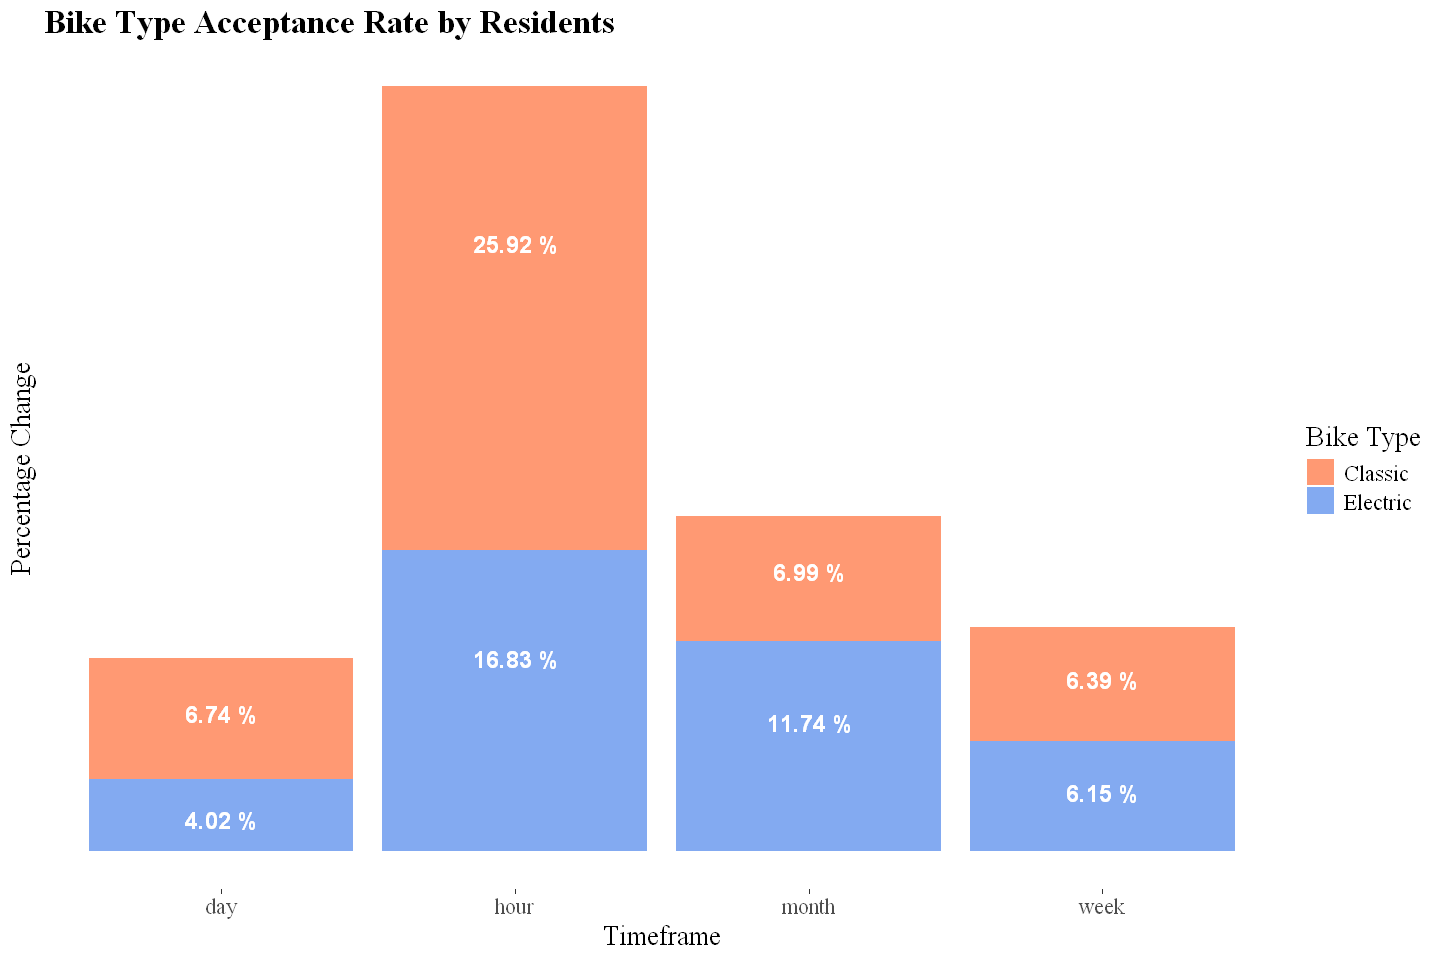

In [29]:
# visualise
fig.size(12,8)
results |> 
    rownames_to_column('name') |> 
    pivot_longer(-name, names_to='bike_type', values_to='pct_change') |>
    ggplot(aes(name, pct_change, fill=bike_type)) +
    geom_col(alpha=0.8, position=position_stack(vjust=0.7)) +
    geom_text(aes(label=paste(round(pct_change,2),'%')), vjust=1.5, size=5,
              color='white', fontface='bold', position=position_stack(vjust=0.7)) + 
    theme_tufte() +
    theme(panel.grid=element_blank(), 
          axis.text.y = element_blank(),
          axis.ticks.y=element_blank(),
          text = element_text(size=16.5),
          plot.title=element_text(face='bold')) + 
    labs(title='Bike Type Acceptance Rate by Residents', 
         x='Timeframe', y='Percentage Change', fill='Bike Type') +
    scale_fill_manual(values=c('coral', 'cornflowerblue'), labels=c('Classic', 'Electric'))

-   When we look at bike demands by bike type, we see that the classic bike type is demanded more than electric bikes per hour and per day. The percentage change in demand per is slightly the same but per month, the demand for electric bikes is higher than for classic bikes. This could indicate that there are some parts of the month when the demand for electric bikes is higher than for classic bikes.

In [30]:
# acceptance by membership status
results <- data.frame(row.names=c('hour', 'week', 'month', 'day'),
                      casual=numeric(4), members=numeric(4))

for (i in 1:2){
    member_type <- c('casual', 'member')[i]

    pct_change <- c()
    for (j in rownames(results)){
        res <- aggregate_data(bike_shares %>% 
                              filter(member_casual == member_type) %>%
                              mutate(date=floor_date(pickup_hour, j[1])), 
                              'num_rides', 'date') %>%
        mutate(pct = 100*(total-lag(total))/lag(total)) %>%
        reframe(avg_change = mean(pct, na.rm=T)) %>%
        pull(avg_change)
        pct_change <- append(pct_change, res)
    }
    results[i] = pct_change
}

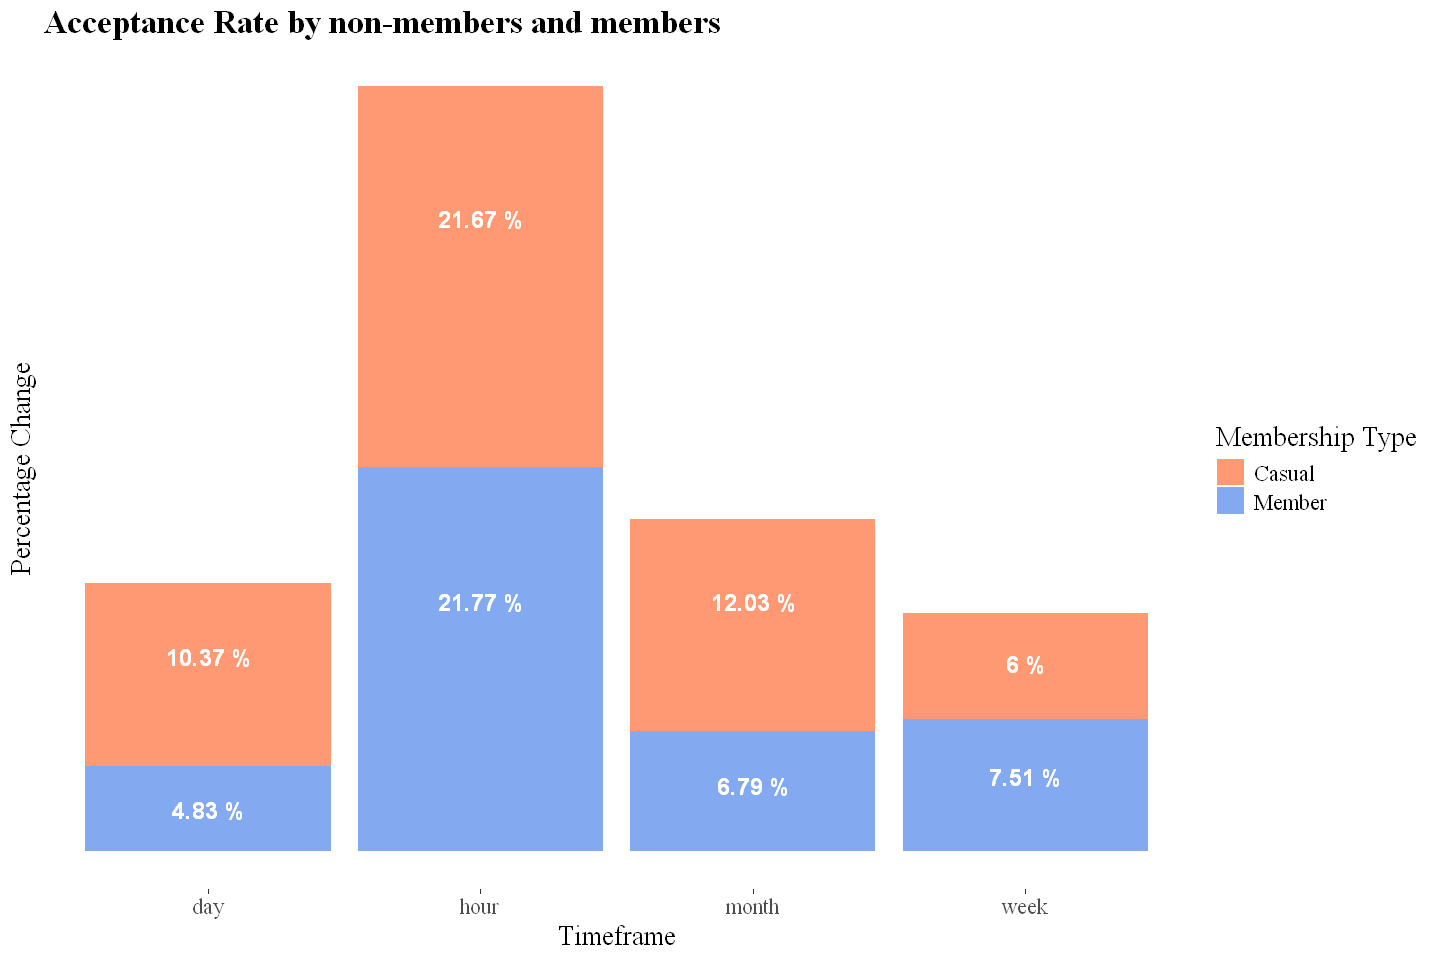

In [31]:
# visualise
fig.size(12,8)
results |> 
    rownames_to_column('name') |> 
    pivot_longer(-name, names_to='member_type', values_to='pct_change') |>
    ggplot(aes(name, pct_change, fill=member_type)) +
    geom_col(alpha=0.8, position=position_stack(vjust=0.7)) +
    geom_text(aes(label=paste(round(pct_change,2),'%')), vjust=1.5, size=5,
              color='white', fontface='bold', position=position_stack(vjust=0.7)) + 
    theme_tufte() +
    theme(panel.grid=element_blank(), 
          axis.text.y = element_blank(),
          text = element_text(size=16.5),
          axis.ticks.y=element_blank(),
          plot.title=element_text(face='bold')) + 
    labs(title='Acceptance Rate by non-members and members', 
         x='Timeframe', y='Percentage Change', fill='Membership Type') +
    scale_fill_manual(values=c('coral', 'cornflowerblue'), labels=c('Casual', 'Member'))


- There's an equal hourly demand rate for casual and registered users
- This is rather different per day where there's a 10.4% increase in bike demand by casual members against the 4.8% by members. This could indicate that there are some parts of the week when bikes are used by casual members
- This is also the same per month and per week of the month, there's a relatively equal demand.

In [32]:
# acceptance by bike type by membership status
results <- data.frame()

for (i in 1:2){
    member_type <- c('casual', 'member')[i]

    pct_change <- data.frame()
    for (j in c('hour', 'week', 'month', 'day')){
        res <- aggregate_data(bike_shares %>% 
                              filter(member_casual == member_type) %>%
                              mutate(date=floor_date(pickup_hour, j[1])), 
                              'num_rides', c('date', 'rideable_type')) %>%
        pivot_wider(id_cols = date, names_from=rideable_type, values_from=total) %>% 
        ungroup() %>%
        mutate(across(where(is.numeric), function(x) 100*(x-lag(x))/lag(x))) %>%
        reframe(across(where(is.numeric), \(x) mean(x, na.rm=T))) %>% unlist()
        pct_change <- rbind(pct_change, c(j, member_type, res))
        names(pct_change) <- c('name', 'member_type', 'classic', 'electric')
        pct_change[, c(3,4)] <- sapply(pct_change[, c(3,4)], as.numeric)
    }
    results <- rbind(results, pct_change)
}

`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'date'. You can override using the `.groups` argument.


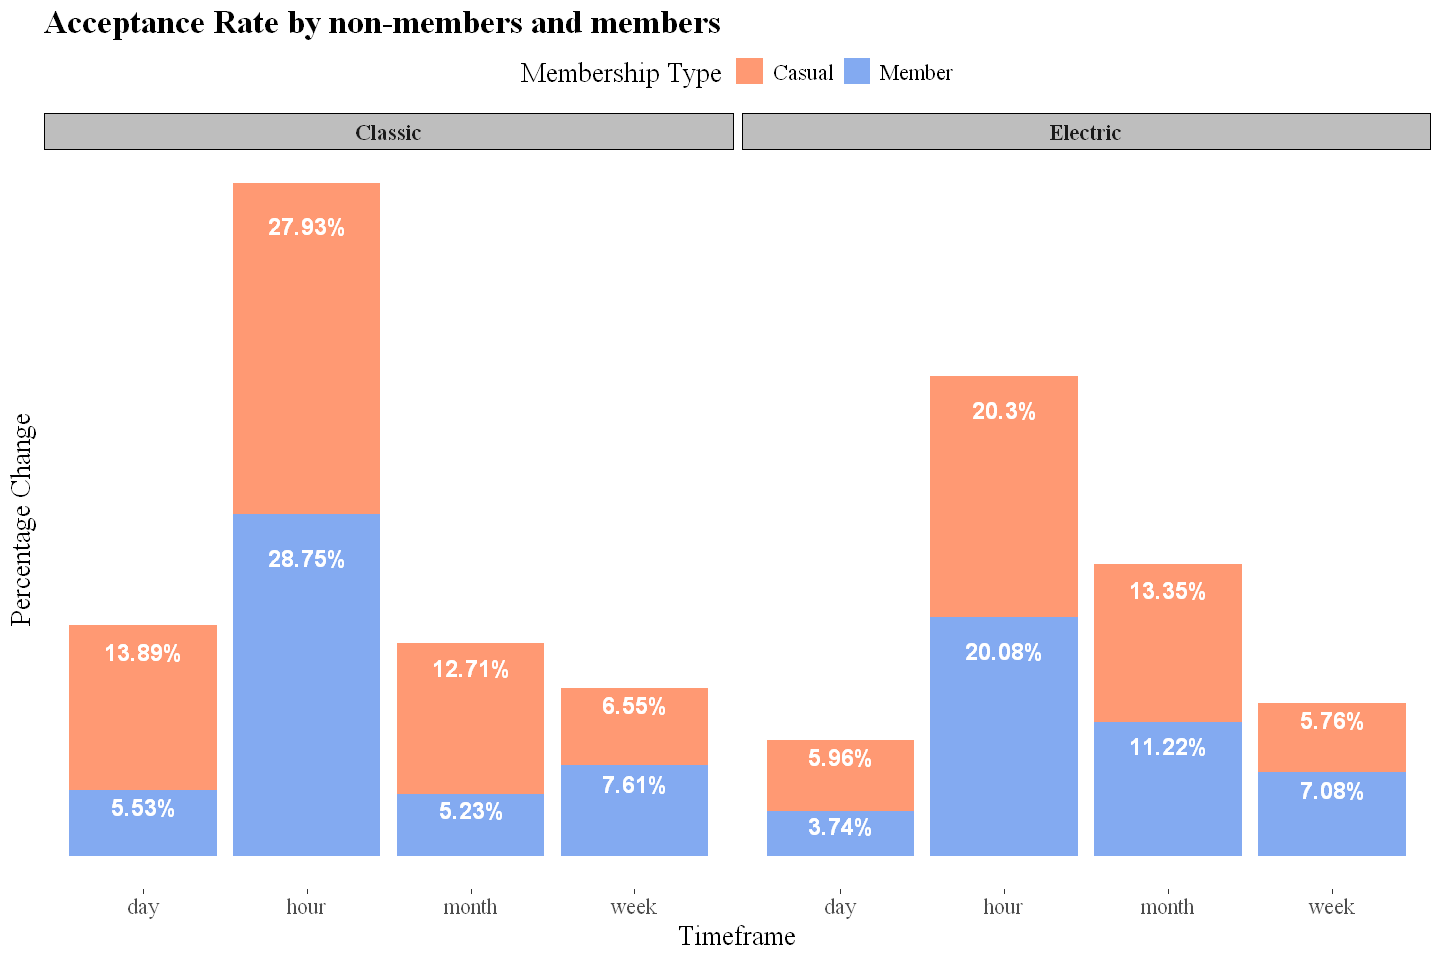

In [33]:
fig.size(12,8)
results |> 
    as.data.frame() |>
    pivot_longer(cols=where(is.numeric), names_to = 'bike_type', values_to='pct_change') |>
    ggplot(aes(name, pct_change, fill=member_type)) +
    geom_col(alpha=0.8, position=position_stack(vjust=0.9), width=0.9) +
    facet_wrap(~bike_type, ncol=2, 
               labeller = as_labeller(c(`electric`='Electric', `classic`='Classic'))) +
    geom_text(aes(label=paste0(round(pct_change,2),'%')), vjust=1., size=5,
              color='white', fontface='bold', position=position_stack(vjust=0.9)) + 
    theme_tufte() +
    theme(panel.grid=element_blank(), 
          text = element_text(size=16.5),
          strip.background=element_rect(fill='gray'),
          strip.text = element_text(face='bold'),
          axis.text.y = element_blank(),
          legend.position='top',
          axis.ticks.y=element_blank(),
          plot.title=element_text(face='bold')) + 
    labs(title='Acceptance Rate by non-members and members', 
         x='Timeframe', y='Percentage Change', fill='Membership Type') +
    scale_fill_manual(values=c('coral', 'cornflowerblue'), labels=c('Casual', 'Member'))

- Generally, classic bikes are demanded by both members and non-members alike than for electric bikes
- On average, there's a 27-29% change in hourly demand by members and non-members for the classic bikes against the 20% for electric bikes.
- Although members use more bikes than non-members, their daily demand for classic bikes is relatively stable at about 5.5% per day against about 14% by non-members. On the other hand, the demand for electric bikes for each membership group is relatively stable, between 3-6% on average.
- A similar demand is seen per month, where casual members are likely to have a 13% increase in classic bikes. This is twice more than that demanded by members.
- On a weekly basis, both classic and electric bikes are demanded almost equally by registered and casual members.

#### What is the temporal variation of bike rides at each time of the year

To do this, we want to look at the number of bikes at each time of the year. Firstly, we will look at the average hourly bike demand over time from Jan 2020 to June 2024. We will aggregate this using a 28-Day window

In [34]:
moving_average <- function(df, n, date_id){
    date <- df[, date_id]
    cols <- names(df)
    n_col = length(cols)
    other_cols <- cols[!grepl(cols[date_id], cols)]
    
    # convert to moving average
    res <- zoo::rollmean(df[,-date_id], n) %>% as.data.frame()
    g <- bind_cols(date[n:nrow(df),], res)
    names(g)[2:n_col] <- other_cols
    g %>% mutate(date = as_date(date))
}

In [35]:
hourly <- aggregate_data(bike_shares %>% mutate(date=floor_date(pickup_hour, 'd')), 
               column='num_rides', group='date', return_perc=F, func=mean) %>% 
    moving_average(28, 1) |>
    ggplot(aes(date, total)) +
    geom_line(color='steelblue', linewidth=0.8) +
    theme_tufte() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          axis.title.x=element_blank(),
          axis.ticks.x=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    labs(y='Number of Bikes', x='') +
    scale_x_date(date_breaks='2 month', date_labels='%b\n%Y', 
                 limits=c(as.Date('2022-01-01'), NA)) +
    scale_y_continuous(breaks=seq(0,200,50))

daily <- aggregate_data(bike_shares %>% mutate(date=floor_date(pickup_hour, 'd')), 
               column='num_rides', groups='date', return_perc=F, func=sum) %>% 
    moving_average(28, 1) |>
    ggplot(aes(date, total)) +
    geom_line(color='red', alpha=0.6, linewidth=0.8) +
    theme_tufte() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    labs( y='Number of Bikes', x='') +
    scale_x_date(date_breaks='2 month', date_labels='%b\n%Y', 
                 limits=c(as.Date('2022-01-01'), NA)) +
    scale_y_continuous(breaks=seq(0,20000,5000))

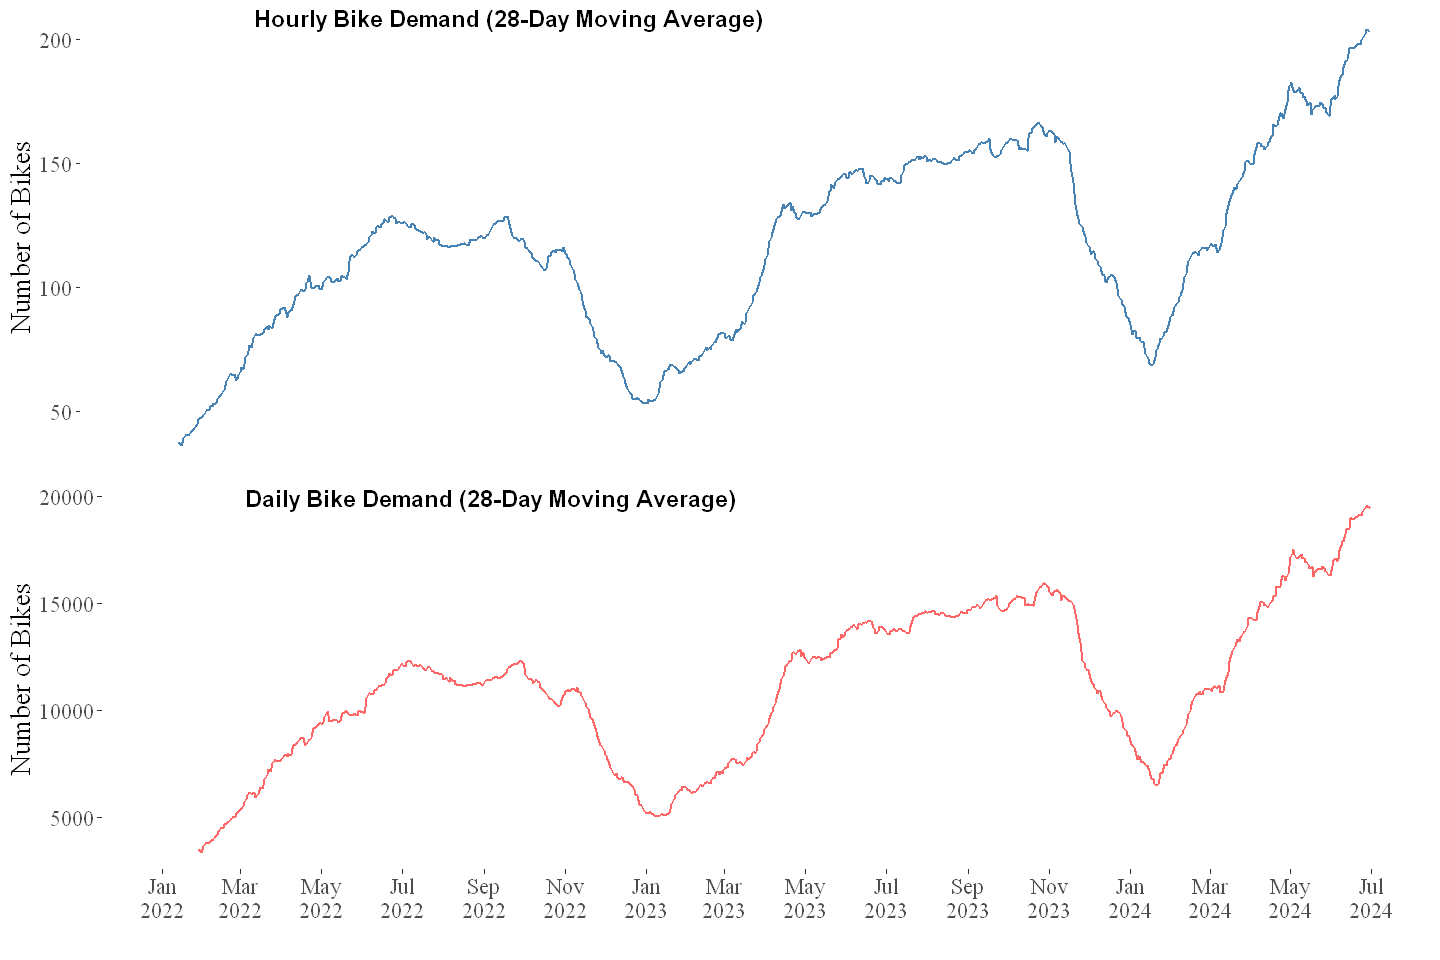

In [36]:
fig.size(12,8)
ggarrange(hourly, daily, nrow = 2,
          labels=c('Hourly Bike Demand (28-Day Moving Average)', 
                   'Daily Bike Demand (28-Day Moving Average)'))

- There is a seasonal effect of bike demand.
- Demand peak in the Summer seasons and declines in the winter season (towards the end of the year).

##### Hourly demand

In [37]:
# hourly demand
a <- aggregate_data(bike_shares, column='num_rides', group=c('hour'), return_perc=F, func=mean) %>% 
    ggline(x='hour', y='total', title = 'Average Hourly Demand', 
           plot_type = 'l' , color='darkgreen', line_type='-', size=.8) +
    theme_tufte() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    labs(x='', y='') +
    scale_y_continuous(breaks=seq(0,300,50)) +
    scale_x_continuous(breaks=seq(0,23,3))

In [38]:
b <- # hourly demand
aggregate_data(bike_shares, column='num_rides', group=c('hour', 'year'), return_perc=F, func=mean) %>% 
    mutate(year=factor(year)) %>%
    ggline(x='hour', y='total', color = 'year', plot_type = 'l', size=0.8) +
    theme_tufte() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          legend.position='top',
          plot.title=element_text(face='bold', size=16)) +
    labs(title='Hourly demand per year', x='Hour of day', y='') +
    scale_y_continuous(breaks=seq(0,400,50)) +
    scale_x_continuous(breaks=seq(0,23,3))

`summarise()` has grouped output by 'hour'. You can override using the `.groups` argument.


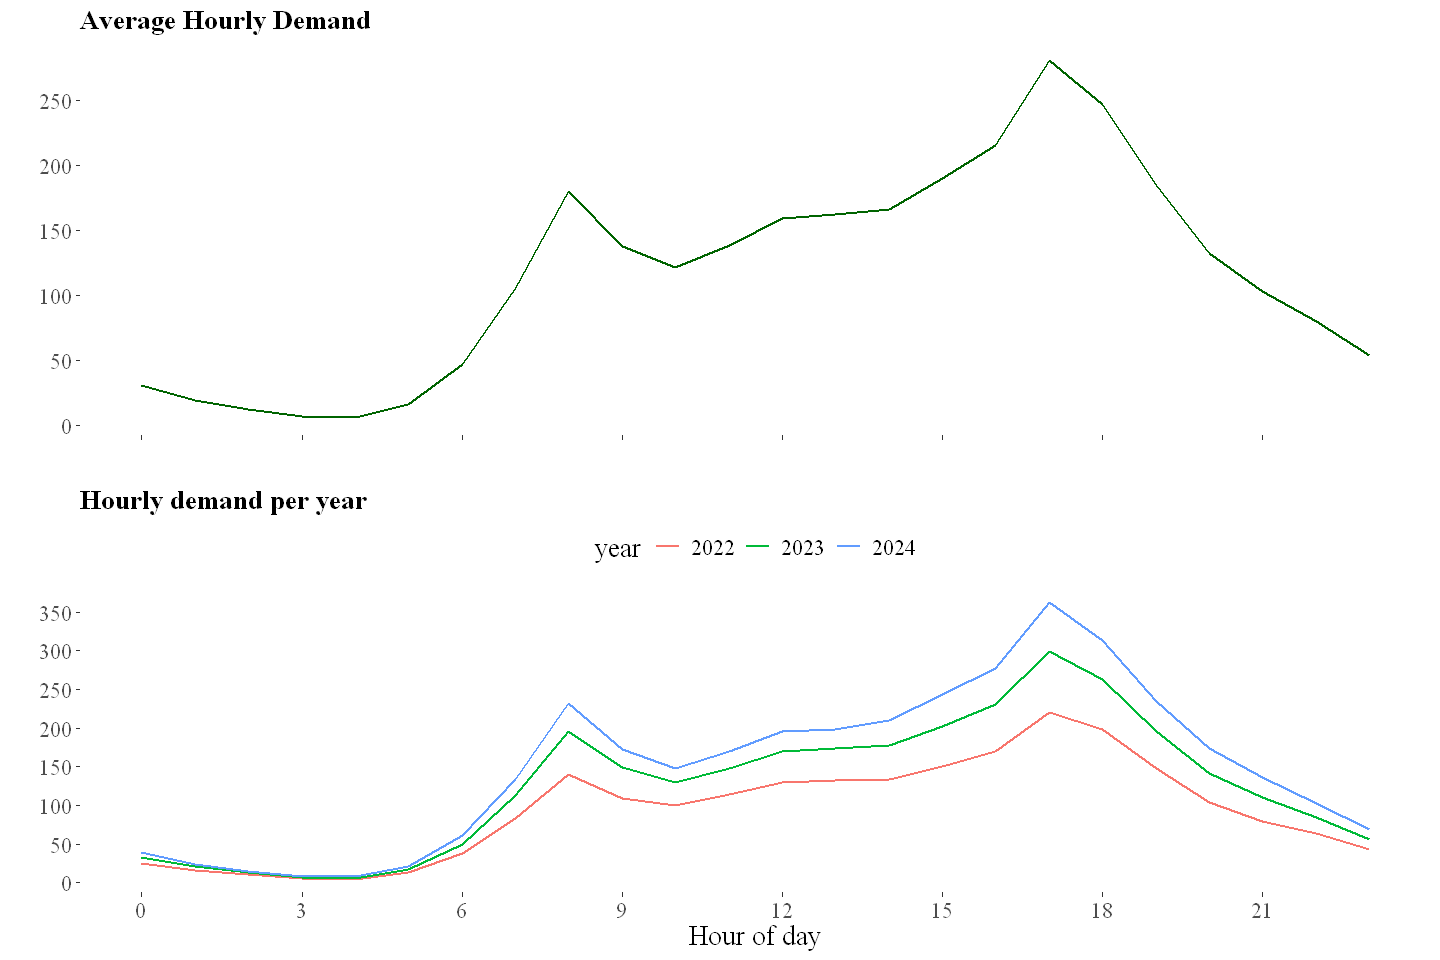

In [39]:
fig.size(12,8)
ggarrange(a,b, ncol=1)

In [40]:
# weekday demand
a <- aggregate_data(bike_shares, column='num_rides', group=c('dow'), return_perc=F, func=mean) %>% 
    ggbarplot(x='dow', y='total', title = 'Average Demand per weekday', 
              fill='cornflowerblue', alpha=0.9) +
    theme_bw() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    scale_y_continuous(breaks=seq(0,120,20)) + 
    labs(x='Day of week', y='Bike rides') 

In [41]:
# hourly demand
# average monthly demand
b <- aggregate_data(bike_shares %>% 
               mutate(month_name = month(pickup_hour, label = T, abbr = T)), column='num_rides', 
               group=c('month_name'), 
               return_perc=F, func=mean) %>%
    ggbarplot(x='month_name', y='total', plot_type = 'l',
           size = .8, fill='steelblue', alpha=0.7) +
    theme_bw() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          strip.text=element_text(face='bold'),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    scale_y_continuous(breaks=seq(0,200,20)) + 
    labs(x='Hour', y='', title='Average Monthly Demand') 

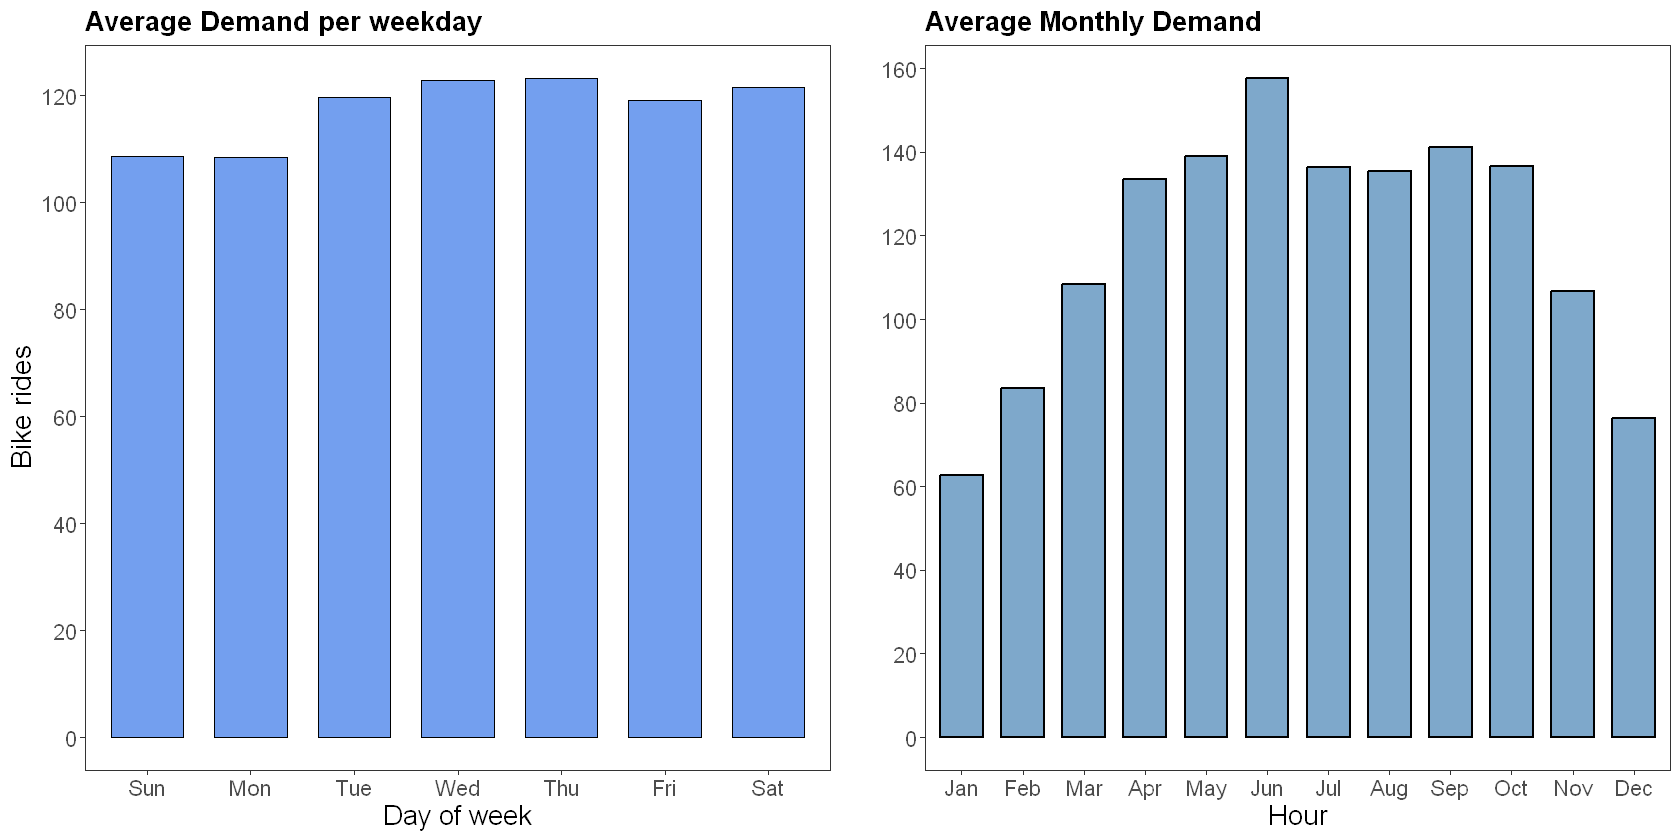

In [42]:
fig.size(14,7)
ggarrange(a, b)

- Bike rentage mainly depends on the hour of the day and the month of the year
- Many People demand bikes during the rush hours (8AM and 6PM) of the day and mostly during spring and summer seasons (Apr-Aug).
- An almost equal amount of bike is rented by resident in all days of the week (at least 100 on average).

#### When are electric and classic bikes mostly rented? 

`summarise()` has grouped output by 'hour', 'member_casual'. You can override using the `.groups` argument.


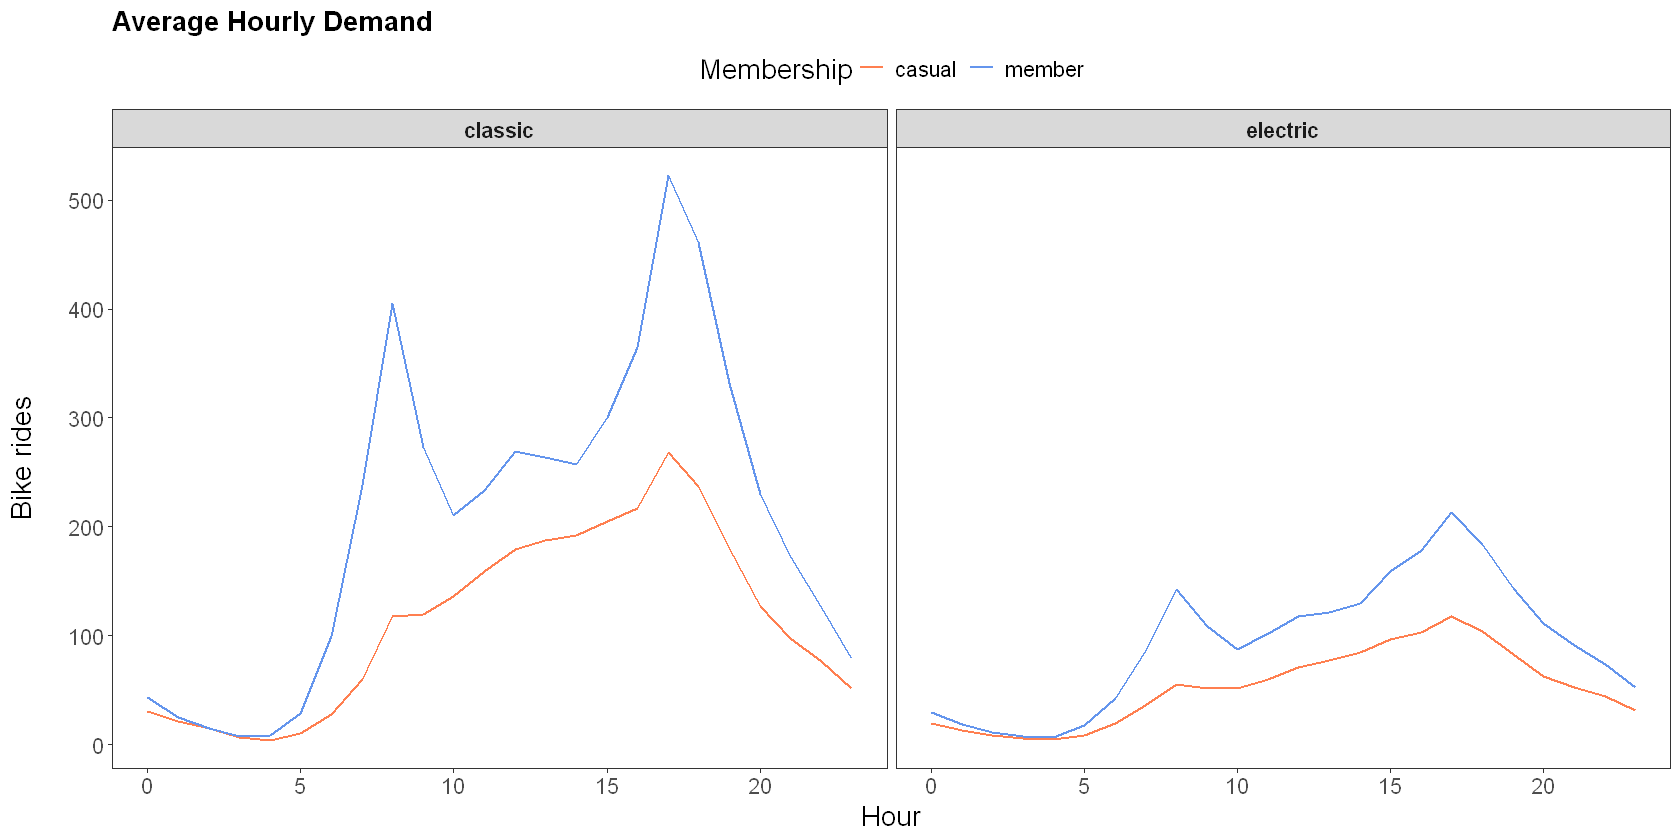

In [43]:
fig.size(14,7)
aggregate_data(bike_shares, column='num_rides', 
               group=c('hour', 'member_casual', 'rideable_type'), 
               return_perc=F, func=mean) %>%
    ggline(x='hour', y='total', plot_type = 'l', facet.by = 'rideable_type',
           size = .8, color='member_casual', alpha=0.7) +
    theme_bw() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          strip.text=element_text(face='bold'),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    scale_y_continuous(breaks=seq(0,500,100)) + 
    labs(x='Hour', y='Bike rides\n', title='Average Hourly Demand') +
    guides(color=guide_legend(title = 'Membership', position='top')) +
    scale_color_manual(values=c('coral', 'cornflowerblue'))

`summarise()` has grouped output by 'month', 'member_casual'. You can override using the `.groups` argument.


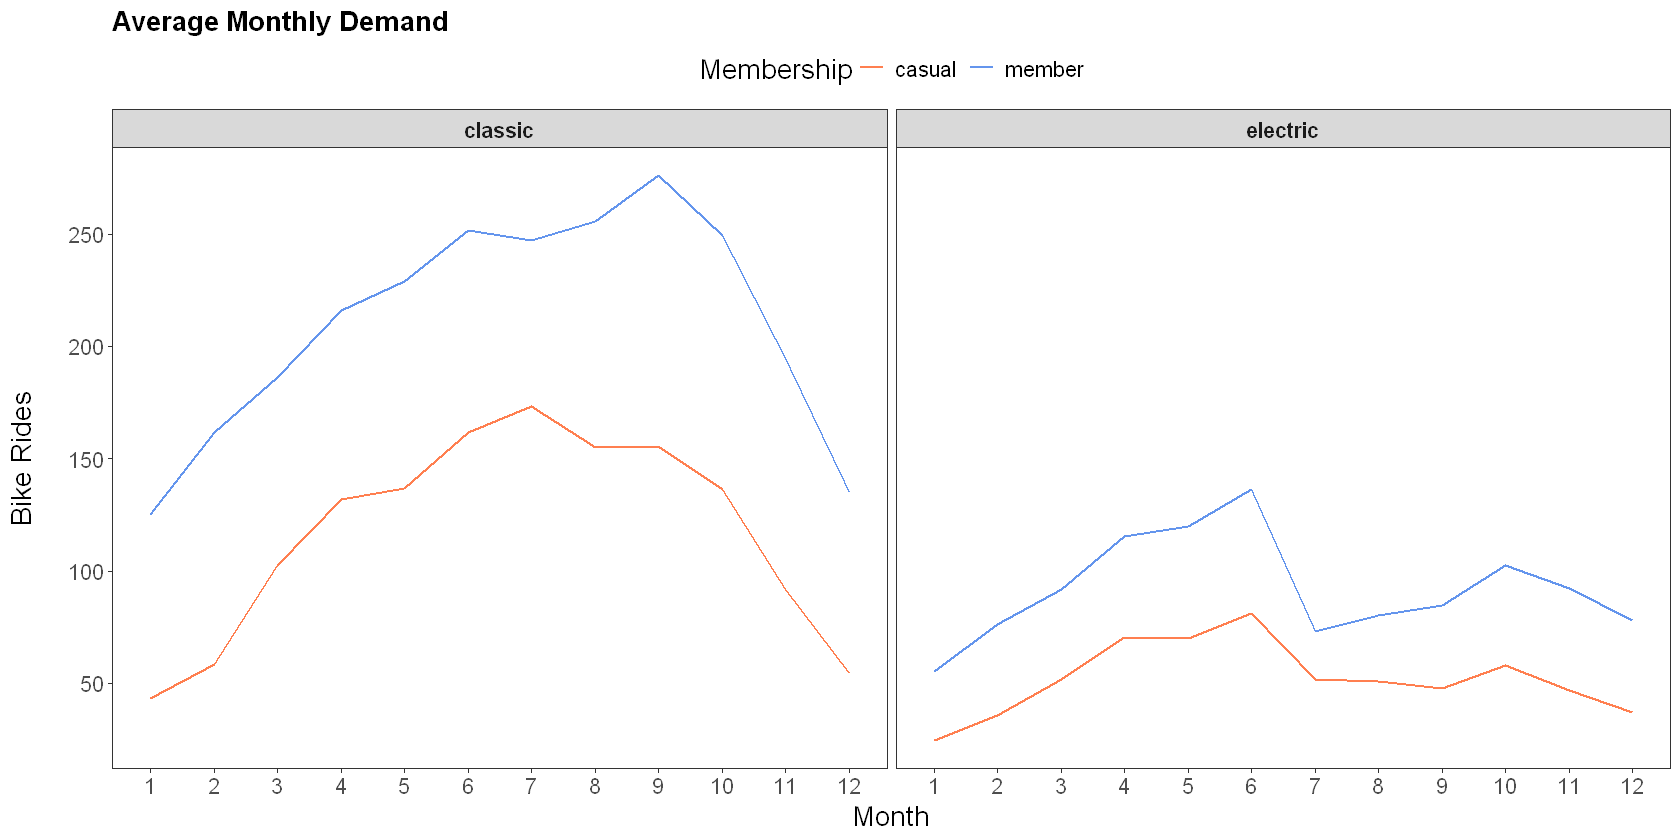

In [44]:
fig.size(14,7)
aggregate_data(bike_shares, column='num_rides', 
               group=c('month', 'member_casual', 'rideable_type'), 
               return_perc=F, func=mean) %>%
    ggline(x='month', y='total', plot_type = 'l', facet.by = 'rideable_type',
           size = .8, color='member_casual', alpha=0.7) +
    theme_bw() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          strip.text=element_text(face='bold'),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    scale_y_continuous(breaks=seq(0,500,50)) + 
    labs(x='Month', y='Bike Rides\n', title='Average Monthly Demand') +
    guides(color=guide_legend(title = 'Membership', position='top')) +
    scale_color_manual(values=c('coral', 'cornflowerblue'))

`summarise()` has grouped output by 'dow', 'member_casual'. You can override using the `.groups` argument.


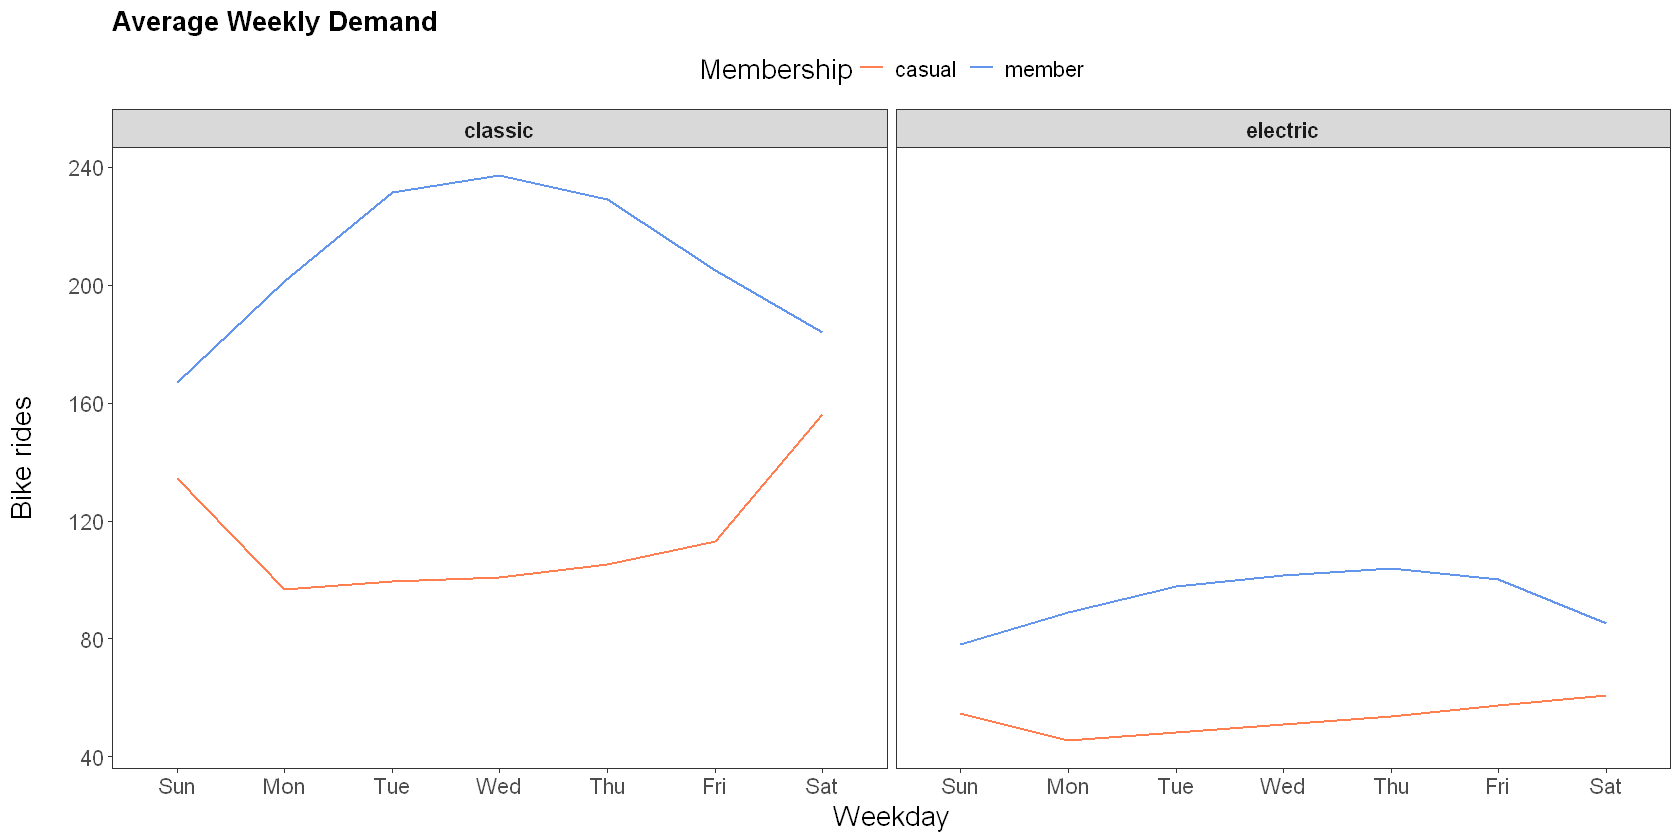

In [45]:
fig.size(14,7)
aggregate_data(bike_shares, column='num_rides', 
               group=c('dow', 'member_casual', 'rideable_type'), 
               return_perc=F, func=mean) %>%
    ggline(x='dow', y='total', plot_type = 'l', facet.by = 'rideable_type',
           size = .8, color='member_casual', alpha=0.7) +
    theme_bw() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          strip.text=element_text(face='bold'),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    scale_y_continuous(breaks=seq(0,250,40)) + 
    labs(x='Weekday', y='Bike rides\n', title='Average Weekly Demand') +
    guides(color=guide_legend(title = 'Membership', position='top')) +
    scale_color_manual(values=c('coral', 'cornflowerblue'))

- The hourly demand for classic and electric bikes by a member or non-member depends on the hour of the day. However, the amount is greater for classic bikes than for electric bikes
- The monthly demand for either bikes by any membership type is affected by the month of the year. For classic bikes, the demand increases from the beginning of the year, peaks at the middle of the year and then declines toward the end of the year. For electric bikes, the decline starts early (July).
- On the other hand, the weekday demands for both casual and registered members are completely different and opposite. There are more bike demands/usage from casual users toward the end of the week while for registered users, it peaks toward the middle of the week and declines toward the end of the week. This may indicate that most casual users are users who use city bikes for weekend activities while registered members could be users who use the city bikes for day-to-day activities like commuting to work, school or any office-related activity.

#### Do members and non-members use classic or electric bikes for long or short distances? 

`summarise()` has grouped output by 'hour', 'rideable_type'. You can override using the `.groups` argument.


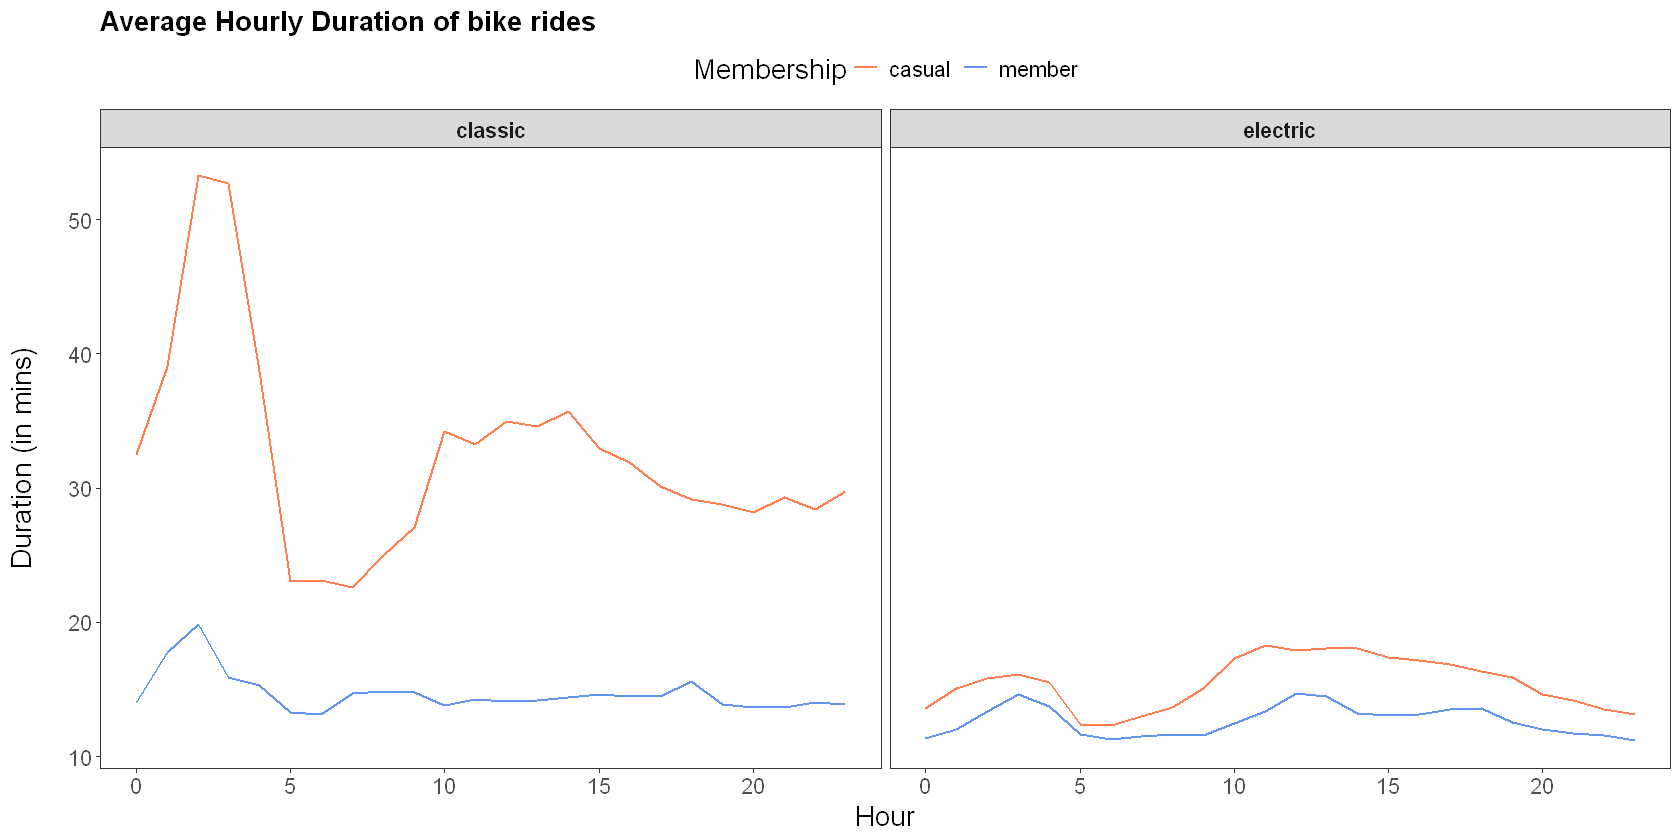

In [46]:
fig.size(14,7)

aggregate_data(bike_shares %>% 
               mutate(av_dist = distance_km/num_rides), 
               column='duration_mins', group=c('hour', 'rideable_type', 'member_casual'), 
               return_perc=F, func=mean) %>% 
    ggline(x='hour', y='total', title = 'Average Hourly Demand', facet.by = 'rideable_type',
           plot_type = 'l' , color='member_casual', line_type='-', size=.8) +
    theme_bw() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          strip.text=element_text(face='bold'),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    # scale_y_continuous(breaks=seq(0,200,20)) + 
    labs(x='Hour', title='Average Hourly Duration of bike rides', y='Duration (in mins)\n') +
    guides(color=guide_legend(title = 'Membership', position = 'top')) +
    scale_color_manual(values=c('coral', 'cornflowerblue'))

`summarise()` has grouped output by 'hour', 'rideable_type'. You can override using the `.groups` argument.


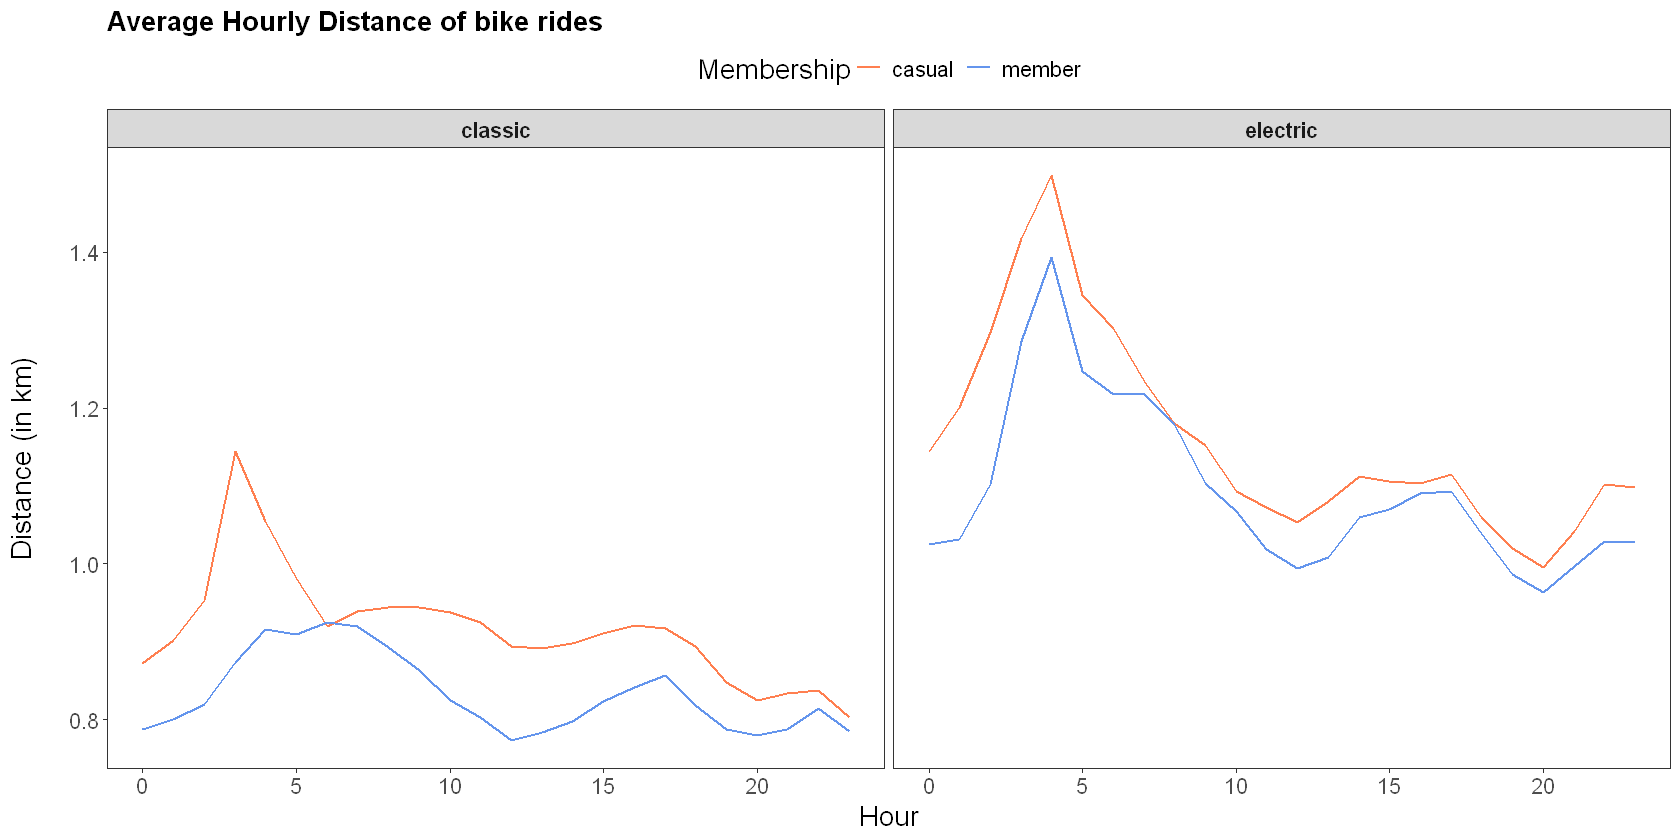

In [47]:
fig.size(14,7)
aggregate_data(bike_shares %>% 
               mutate(av_dist = distance_km/num_rides), 
               column='av_dist', group=c('hour', 'rideable_type', 'member_casual'), 
               return_perc=F, func=mean) %>% 
    ggline(x='hour', y='total', title = 'Average Hourly Demand', facet.by = 'rideable_type',
           plot_type = 'l' , color='member_casual', line_type='-', size=.8) +
    theme_bw() +
    theme(text=element_text(size=16.5), 
          panel.grid=element_blank(),
          strip.text=element_text(face='bold'),
          axis.text.x=element_text(size=13),
          axis.text.y=element_text(size=13),
          plot.title=element_text(face='bold', size=16)) +
    # scale_y_continuous(breaks=seq(0,200,20)) + 
    labs(x='Hour', title='Average Hourly Distance of bike rides', y='Distance (in km)\n') +
    guides(color=guide_legend(title = 'Membership', position = 'top')) +
    scale_color_manual(values=c('coral', 'cornflowerblue'))